In [ ]:
! pip install readability-lxml
! pip install lxml[html_clean]
! pip install beautifulsoup4
! pip install requests
! pip install newspaper3k

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 61.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 52.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 6.7 MB/s eta 0:00:00
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13539 sha256=0439a057acd17da13ef58cdf8d48d837a56e7a0d4339af9bc601ffa52c206c90
  Stored in directory: /root/.cache/pip/wheels/c8/d6/6c/384f58df48c00b9a31d638005143b5b3ac62c3d25fb1447f23
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3342 sha25

In [ ]:
import requests
import re
import pandas as pd
import time
from concurrent.futures import ThreadPoolExecutor
from bs4 import BeautifulSoup
from readability import Document
from newspaper import Article
from urllib.parse import urljoin
from datetime import datetime

In [ ]:
class ArticleDateExtractor:
    """ This method could automatically figure out which kind of function we should use to get the published year of articles. """

    def __init__(self, url):
        self.url = url

    def get_time(self):
        """ Some articles' website URLs contain the published time, so we could directly extract the published year from the URL. """
        match = re.search(r'/(\d{4})/(\d{2})/(\d{2})/', self.url)
        if match:
            year, month, day = match.groups()
            return year

    def get_time_rtnc(self):
        """ For articles in RTNC, the URL does not contain the published time, so we inspect the page source of HTML to
            find the general published time tag and its format to get the published year.
        """
        response = requests.get(self.url)
        page_content = response.content
        soup = BeautifulSoup(page_content, 'html.parser')
        date_meta = soup.find("meta", property="article:published_time")
        if date_meta:
            date_str = date_meta.get("content")
            year = datetime.fromisoformat(date_str).year
            return year

    def extract_year(self):
        """ Since we have many different CSVs of URLs, we are using their names to decide which method to use. """
        if "okapi" in self.url or "actualite" in self.url or "7sur7" in self.url:
            return self.get_time()
        else:
            return self.get_time_rtnc()


In [ ]:
def extract_articles(url, retries=3, delay=2):
    for attempt in range(retries):
        """ We set retries and delay to avoid limitations and block problems of websites. """
        try:
            response = requests.get(url)
            doc = Document(response.text)
            cleaned_html = doc.summary()
            soup = BeautifulSoup(cleaned_html, 'html.parser')
            text = soup.get_text()
            text = ' '.join(text.split())
            return text

        except requests.exceptions.RequestException as e:
            time.sleep(delay)
    return None

def parallel_process(urls):
  ''' We used parallel processing to make running time faster. '''
  with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(extract_articles, urls))
  return results

In [ ]:
rtnc = pd.read_csv("/content/RTNC.csv")
urls = rtnc['Source'].tolist()
rtnc['Articles'] = parallel_process(urls)
rtnc['Year'] = rtnc['Source'].apply(lambda x: ArticleDateExtractor(x).extract_year())
#rtnc.to_csv('/content/Extracted_RTNC.csv', index=False)

In [ ]:
okapi = pd.read_csv("/content/Radio Okapi.csv")
urls = okapi['Source'].tolist()
okapi['Articles'] = parallel_process(urls)
okapi['Year'] = okapi['Source'].apply(lambda x: ArticleDateExtractor(x).extract_year())
#okapi.to_csv('/content/Extracted_okapi.csv', index=False)

In [ ]:
actualite = pd.read_csv("/content/Actualite.csv")
urls = actualite['Source'].tolist()
actualite['Articles'] = parallel_process(urls)
actualite['Year'] = actualite['Source'].apply(lambda x: ArticleDateExtractor(x).extract_year())
#actualite.to_csv('/content/Extracted_Actualite.csv', index=False)

In [ ]:
sur7 = pd.read_csv("/content/7SUR7.csv")
urls = sur7['Source'].tolist()
sur7['Articles'] = parallel_process(urls)
sur7['Year'] = sur7['Source'].apply(lambda x: ArticleDateExtractor(x).extract_year())
#sur7.to_csv('/content/Extracted_7sur7.csv', index=False)

## Sentiment Analysis

In [ ]:
! pip install tensorflow-cpu


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.0/230.0 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.3/381.3 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does 

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


In [ ]:
rtnc = pd.read_csv("/content/Extracted_RTNC.csv")
okapi = pd.read_csv("/content/Extracted_okapi.csv")
actualite = pd.read_csv("/content/Extracted_Actualite.csv")
sur7 = pd.read_csv("/content/Extracted_7sur7.csv")

## BERT Multilingual Model

In [ ]:
# Load a sentiment-specific model and tokenizer from huggingface
# https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Define function to predict sentiment and degree
def analyze_sentiment(text):
    '''Initially, we set up the hyperparameters such as truncation for less processing time, and max_length for
    processing tokens limit. '''
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits

    # This model used softmax as activation function to outputs
    probabilities = F.softmax(logits, dim=1).squeeze().tolist()
    sentiment = logits.argmax().item()

    #  This model predicts the sentiment of the review as a number of stars (between 1 and 5), so we assign sentiment labels for better understanding
    sentiment_labels = ["very negative", "negative", "neutral", "positive", "very positive"]
    sentiment_label = sentiment_labels[sentiment]
    degree = probabilities[sentiment]

    return pd.Series([sentiment_label, degree])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

### RTNC

In [ ]:
rtnc[['sentiment', 'degree']] = rtnc['Articles'].apply(analyze_sentiment)
rtnc.head()

,Source,Articles,Year,sentiment,degree
0,https://rtnc.cd/nord-kivu-40-presumes-criminel...,Une quarantaine de présumés criminels et 6 arm...,2024,positive,0.229060
1,https://rtnc.cd/nord-kivu-les-gardiens-de-cout...,Dans une assise tenue ce lundi 30 Septembre 30...,2024,very negative,0.232342
2,https://rtnc.cd/nord-kivu-les-terroristes-du-m...,Le Directeur Balume Hangi de la radio communau...,2024,very negative,0.356044
3,https://rtnc.cd/nord-kivu-des-recruteurs-du-m2...,Les services de sécurité en ville de goma ont ...,2024,positive,0.363254
4,https://rtnc.cd/nord-kivu-un-camp-de-transit-e...,Plus de 500 volontaires pour la défense de la ...,2024,positive,0.264874


In [ ]:
rtnc.to_csv('/content/Multilingual Bert RTNC.csv', index=False)

### Okapi

In [ ]:
okapi['Articles'] = okapi['Articles'].fillna("").astype(str)
okapi[['sentiment', 'degree']] = okapi['Articles'].apply(analyze_sentiment)
okapi.head()

,Source,Articles,Year,sentiment,degree
0,https://www.radiookapi.net/2020/01/09/actualit...,"L’armée dit avoir neutralisé, durant l’année 2...",2020,very negative,0.311421
1,https://www.radiookapi.net/2020/02/20/actualit...,Revue de presse du jeudi 20 février 2020 Les j...,2020,very negative,0.305000
2,https://www.radiookapi.net/2020/06/01/actualit...,"Des affrontements ont opposé, dimanche 31 mai ...",2020,positive,0.337056
3,https://www.radiookapi.net/2020/07/25/actualit...,"Publié le sam, 25/07/2020 - 15:11 | Modifié le...",2020,very negative,0.453834
4,https://www.radiookapi.net/2020/08/10/actualit...,La société civile du secteur de Rwenzori salue...,2020,positive,0.415691


In [ ]:
okapi.to_csv('/content/Multilingual Bert Okapi.csv', index=False)

### Actualite

In [ ]:
actualite[['sentiment', 'degree']] = actualite['Articles'].apply(analyze_sentiment)
actualite.head()

,Source,Articles,Year,sentiment,degree
0,https://actualite.cd/2020/07/16/rdc-la-quadrip...,"L'International Crisis Group (ICG), dans un ra...",2020,positive,0.344058
1,https://actualite.cd/2020/07/16/rdc-ituri-des-...,Certains membres de l’ancien mouvement rebelle...,2020,positive,0.262962
2,https://actualite.cd/2020/07/21/rdc-rutshuru-u...,Une position de l’Armée a été attaquée la nuit...,2020,negative,0.301689
3,https://actualite.cd/2020/07/22/rdc-nouveaux-a...,Les combats ont éclaté ce mercredi 22 juillet ...,2020,positive,0.275983
4,https://actualite.cd/2020/07/30/rdc-face-linse...,"La ville de Goma abritte ce jeudi 30 juillet, ...",2020,positive,0.408559


In [ ]:
actualite.to_csv('/content/Multilingual Bert Actualite.csv', index=False)

### 7SUR7

In [ ]:
sur7[['sentiment', 'degree']] = sur7['Articles'].apply(analyze_sentiment)
sur7['Year'] = pd.to_datetime(sur7['Year'])
sur7.head()

,Source,Articles,Year,sentiment,degree
0,https://7sur7.cd/index.php/2020/02/13/tribune-...,Des ONG congolaises des droits de l’homme appe...,1970-01-01 00:00:00.000002020,positive,0.282840
1,https://7sur7.cd/index.php/2020/08/05/la-sadc-...,Le président de la République Félix Tshisekedi...,1970-01-01 00:00:00.000002020,negative,0.280116
2,https://7sur7.cd/index.php/2020/09/17/butembo-...,Les militants pro-démocratie de la Lutte pour ...,1970-01-01 00:00:00.000002020,very negative,0.255466
3,https://7sur7.cd/index.php/2020/10/14/rdc-kivu...,"Les hauts plateaux du Sud-Kivu, dans la partie...",1970-01-01 00:00:00.000002020,very negative,0.356518
4,https://7sur7.cd/index.php/2020/08/29/sud-kivu...,"Le ministre de l'intérieur, Gilbert Kankonde, ...",1970-01-01 00:00:00.000002020,neutral,0.247792


In [ ]:
sur7.to_csv('/content/Multilingual Bert 7sur7.csv', index=False)

## Multilingual Visualization

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

RTNC = pd.read_csv("Multilingual Bert RTNC.csv")
Okapi = pd.read_csv("Multilingual Bert Okapi.csv")
Actualite = pd.read_csv("Multilingual Bert Actualite.csv")
Sur7 = pd.read_csv("Multilingual Bert 7sur7.csv")

In [39]:
sentiment_order = ['very negative', 'negative', 'neutral', 'positive', 'very positive']
colors = ['#fcb2af', '#9bdfdf', '#ffe2ce', '#c4d8e9', '#bebcdf']

### RTNC Sentiment Distribution and Modification

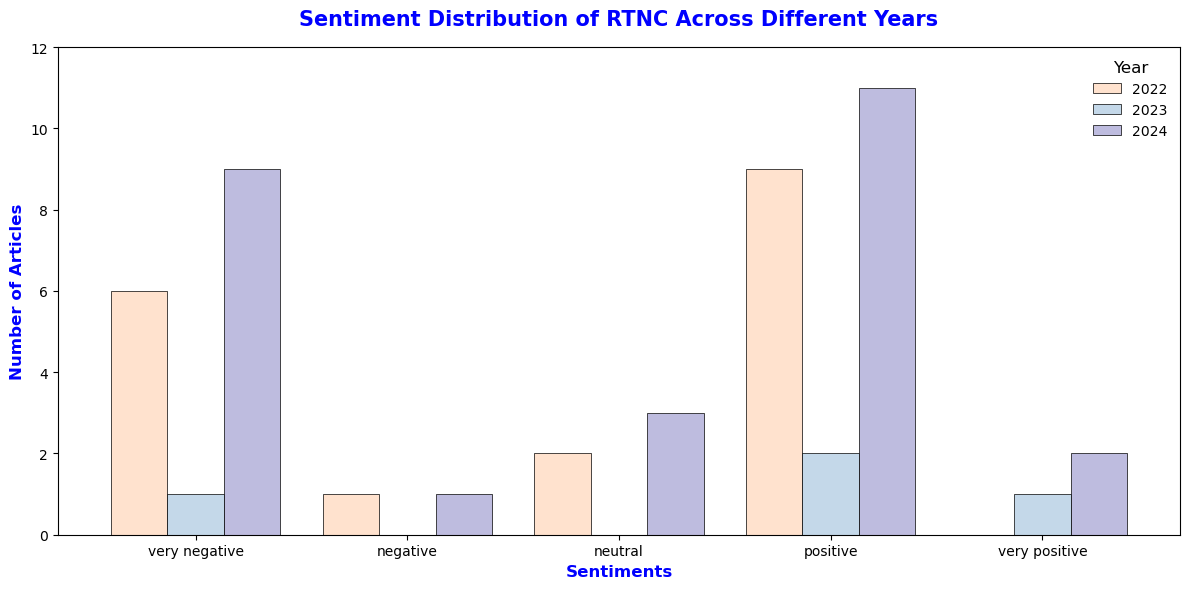

In [ ]:
sentiment_distribution = RTNC.groupby(['Year', 'sentiment']).size().unstack(fill_value=0)

sentiment_order = [col for col in sentiment_order if col in sentiment_distribution.columns]
sentiment_distribution = sentiment_distribution[sentiment_order].T

colors_rtnc = ['#ffe2ce', '#c4d8e9', '#bebcdf']
sentiment_distribution.plot(kind='bar', figsize=(12, 6), width=0.8, color = colors_rtnc, edgecolor='black', linewidth=0.5)
plt.gcf().set_facecolor('white')
plt.gcf().set_edgecolor('blue')

plt.title('Sentiment Distribution of RTNC Across Different Years', fontsize=15, color='blue', fontweight='bold', loc='center', pad=16)
plt.xlabel('Sentiments', fontsize=12, color='blue', fontweight='bold')
plt.ylabel('Number of Articles', fontsize=12, color='blue', fontweight='bold')
plt.xticks(rotation=0)
plt.ylim(0, 12)
plt.legend(title='Year', title_fontsize='12', fontsize='10', loc='upper right', frameon=False)
plt.tight_layout()

plt.savefig('RTNC Distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### Radio Okapi Sentiment Distribution and Modification

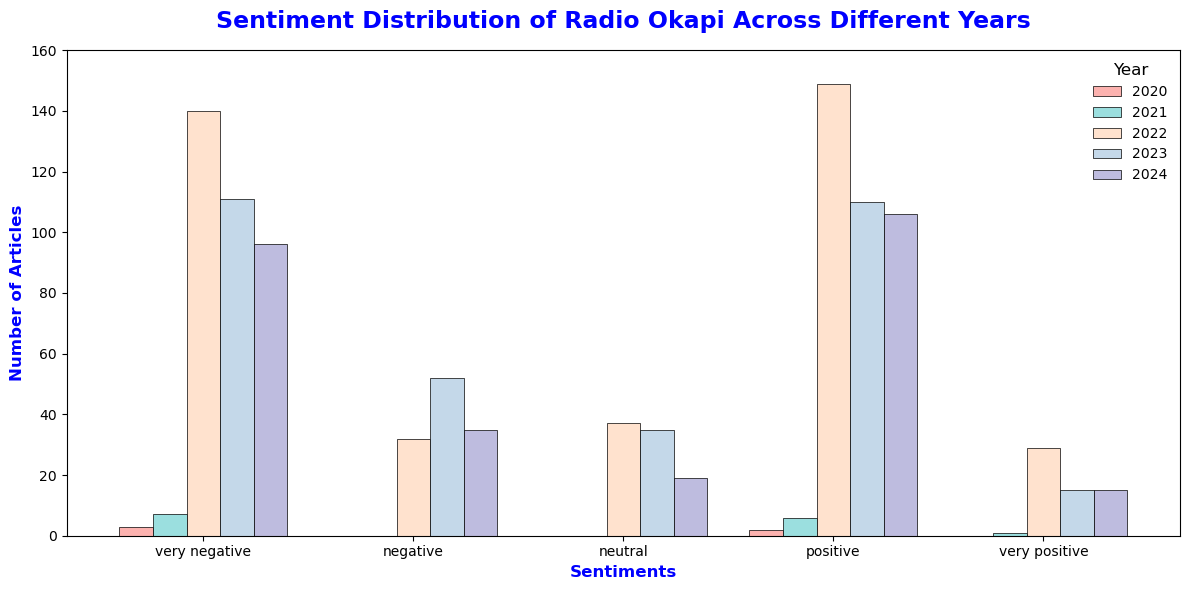

In [ ]:
sentiment_distribution = Okapi.groupby(['Year', 'sentiment']).size().unstack(fill_value=0)
sentiment_order = [col for col in sentiment_order if col in sentiment_distribution.columns]
sentiment_distribution = sentiment_distribution[sentiment_order].T

sentiment_distribution.plot(kind='bar', figsize=(12, 6), width=0.8, color = colors, edgecolor='black', linewidth=0.5)
plt.gcf().set_facecolor('white')
plt.gcf().set_edgecolor('blue')

plt.title('Sentiment Distribution of Radio Okapi Across Different Years', fontsize=17, color='blue', fontweight='bold', loc='center', pad=16)
plt.xlabel('Sentiments', fontsize=12, color='blue', fontweight='bold')
plt.ylabel('Number of Articles', fontsize=12, color='blue', fontweight='bold')
plt.xticks(rotation=0)
plt.ylim(0, 160)
plt.legend(title='Year', title_fontsize='12', fontsize='10', loc='upper right', frameon=False)
plt.tight_layout()

plt.savefig('Okapi Distribution.png', dpi=300, bbox_inches='tight')
plt.show()


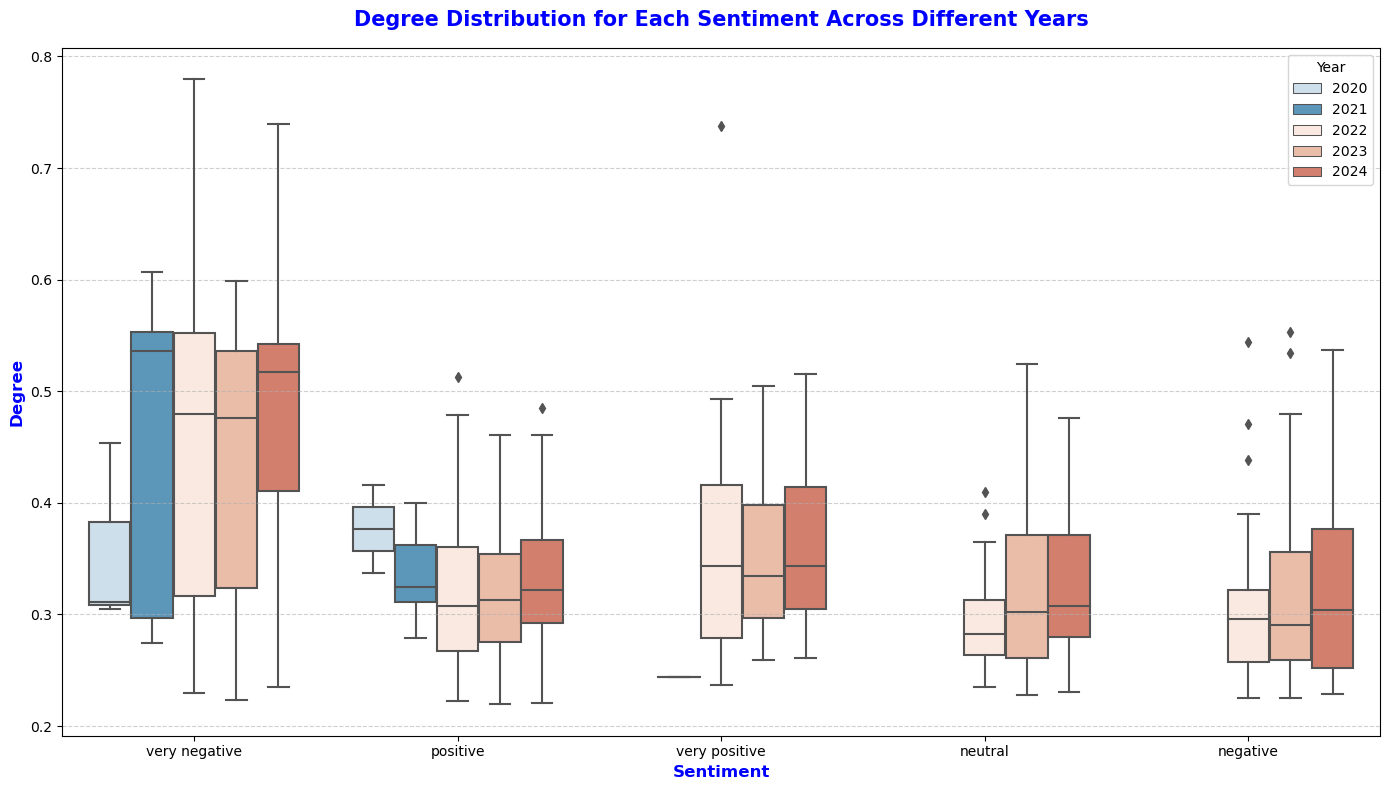

In [ ]:
plt.figure(figsize=(14, 8))

custom_colors = ['#c8e0ef', '#4c9ac9', '#fee8dd', '#f5b99e', '#e2745e']
box = sns.boxplot(x='sentiment', y='degree', hue='Year', data=Okapi, palette=custom_colors)

plt.title('Degree Distribution for Each Sentiment Across Different Years', fontsize=15, color='blue', fontweight='bold', loc='center', pad=16)
plt.xlabel('Sentiment', fontsize=12, color='blue', fontweight='bold')
plt.ylabel('Degree', fontsize=12, color='blue', fontweight='bold')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig('Okapi Degree.png', dpi=300, bbox_inches='tight')
plt.show()

### Actualite Sentiment Distribution and Modification

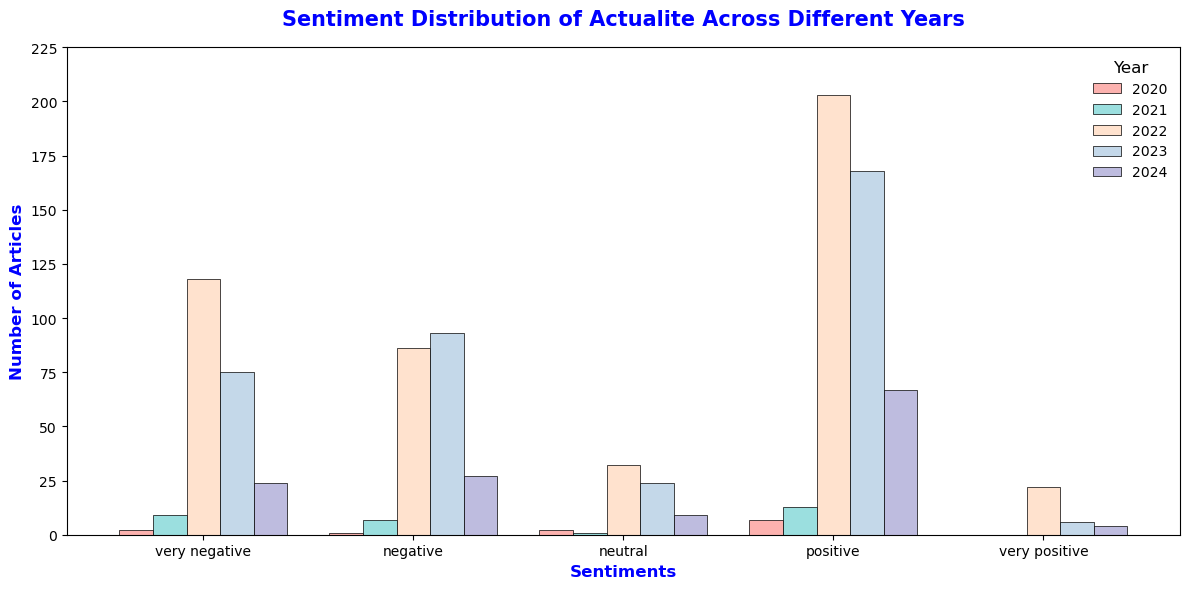

In [ ]:
sentiment_distribution = Actualite.groupby(['Year', 'sentiment']).size().unstack(fill_value=0)
sentiment_order = [col for col in sentiment_order if col in sentiment_distribution.columns]
sentiment_distribution = sentiment_distribution[sentiment_order].T

sentiment_distribution.plot(kind='bar', figsize=(12, 6), width=0.8, color = colors, edgecolor='black', linewidth=0.5)
plt.gcf().set_facecolor('white')
plt.gcf().set_edgecolor('blue')

plt.title('Sentiment Distribution of Actualite Across Different Years', fontsize=15, color='blue', fontweight='bold', loc='center', pad=16)
plt.xlabel('Sentiments', fontsize=12, color='blue', fontweight='bold')
plt.ylabel('Number of Articles', fontsize=12, color='blue', fontweight='bold')
plt.xticks(rotation=0)
plt.ylim(0, 225)
plt.legend(title='Year', title_fontsize='12', fontsize='10', loc='upper right', frameon=False)
plt.tight_layout()

plt.savefig('Actualite Distribution.png', dpi=300, bbox_inches='tight')
plt.show()

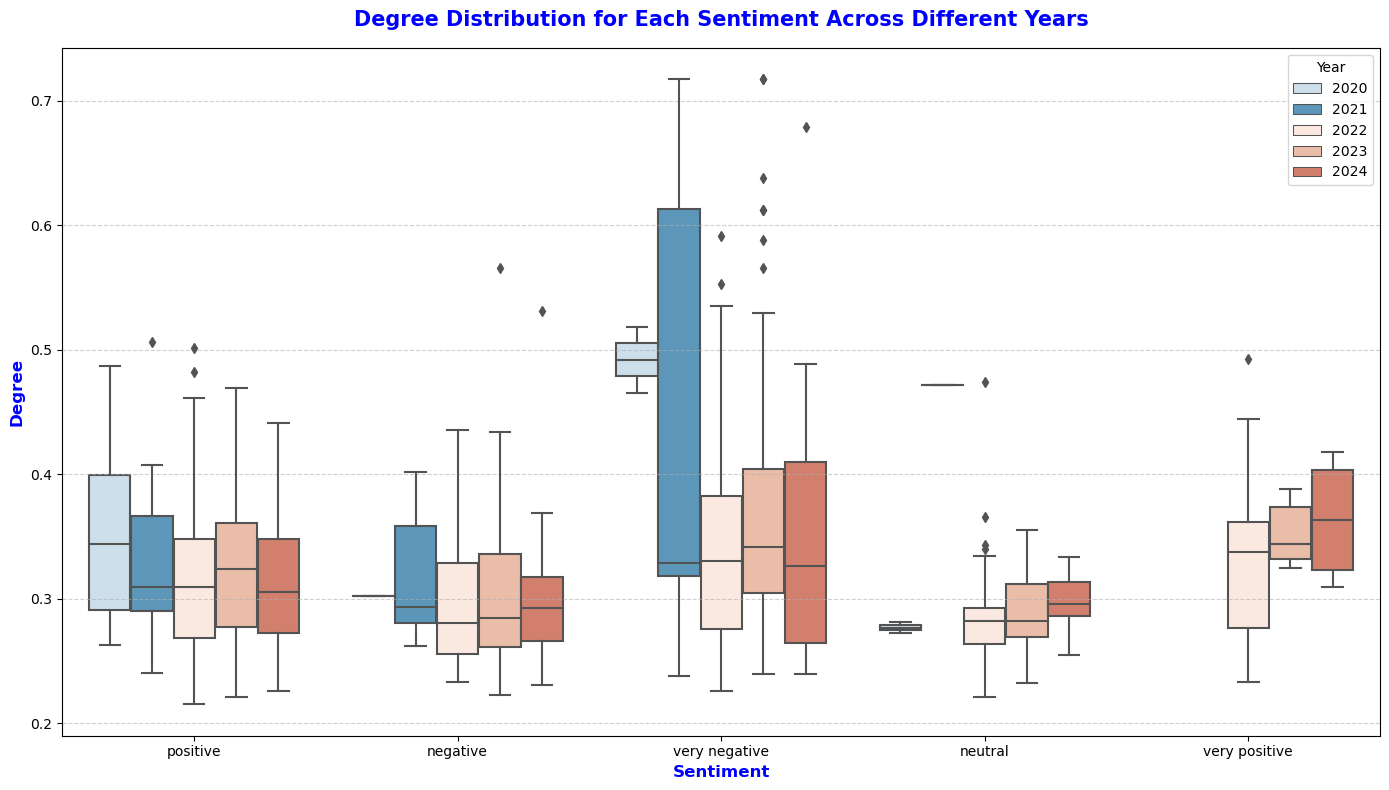

In [ ]:
plt.figure(figsize=(14, 8))

custom_colors = ['#c8e0ef', '#4c9ac9', '#fee8dd', '#f5b99e', '#e2745e']
box = sns.boxplot(x='sentiment', y='degree', hue='Year', data=Actualite, palette=custom_colors)

plt.title('Degree Distribution for Each Sentiment Across Different Years', fontsize=15, color='blue', fontweight='bold', loc='center', pad=16)
plt.xlabel('Sentiment', fontsize=12, color='blue', fontweight='bold')
plt.ylabel('Degree', fontsize=12, color='blue', fontweight='bold')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig('Actualite Degree.png', dpi=300, bbox_inches='tight')
plt.show()

### 7SUR7 Sentiment Distribution and Modification

/var/folders/j9/njfzxqvs1x5byd3zfx3c000c0000gn/T/ipykernel_37813/333499431.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Sur7['Year'] = Sur7['Source'].apply(lambda x: int(re.search(r'/(\d{4})/', x).group(1)) if pd.notna(x) and re.search(r'/(\d{4})/', x) else pd.NA)


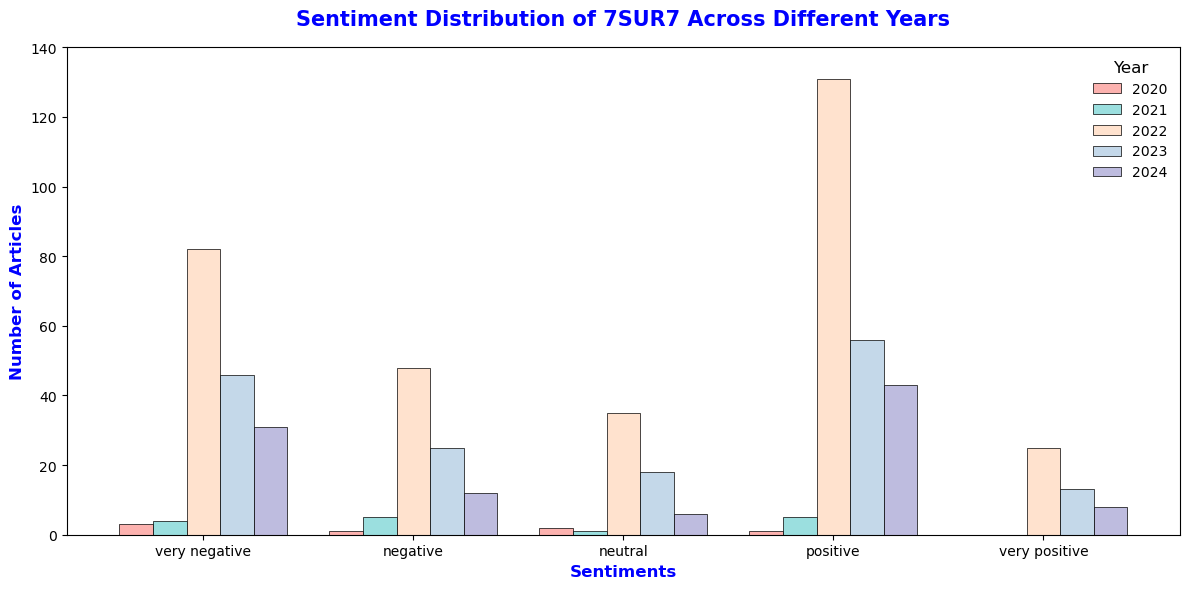

In [ ]:
Sur7['Year'] = Sur7['Source'].apply(lambda x: int(re.search(r'/(\d{4})/', x).group(1)) if pd.notna(x) and re.search(r'/(\d{4})/', x) else pd.NA)
sentiment_distribution = Sur7.groupby(['Year', 'sentiment']).size().unstack(fill_value=0)
sentiment_order = [col for col in sentiment_order if col in sentiment_distribution.columns]
sentiment_distribution = sentiment_distribution[sentiment_order].T

sentiment_distribution.plot(kind='bar', figsize=(12, 6), width=0.8, color = colors, edgecolor='black', linewidth=0.5)
plt.gcf().set_facecolor('white')
plt.gcf().set_edgecolor('blue')

plt.title('Sentiment Distribution of 7SUR7 Across Different Years', fontsize=15, color='blue', fontweight='bold', loc='center', pad=16)
plt.xlabel('Sentiments', fontsize=12, color='blue', fontweight='bold')
plt.ylabel('Number of Articles', fontsize=12, color='blue', fontweight='bold')
plt.xticks(rotation=0)
plt.ylim(0, 140)
plt.legend(title='Year', title_fontsize='12', fontsize='10', loc='upper right', frameon=False)
plt.tight_layout()

plt.savefig('7sur7 Distribution.png', dpi=300, bbox_inches='tight')
plt.show()

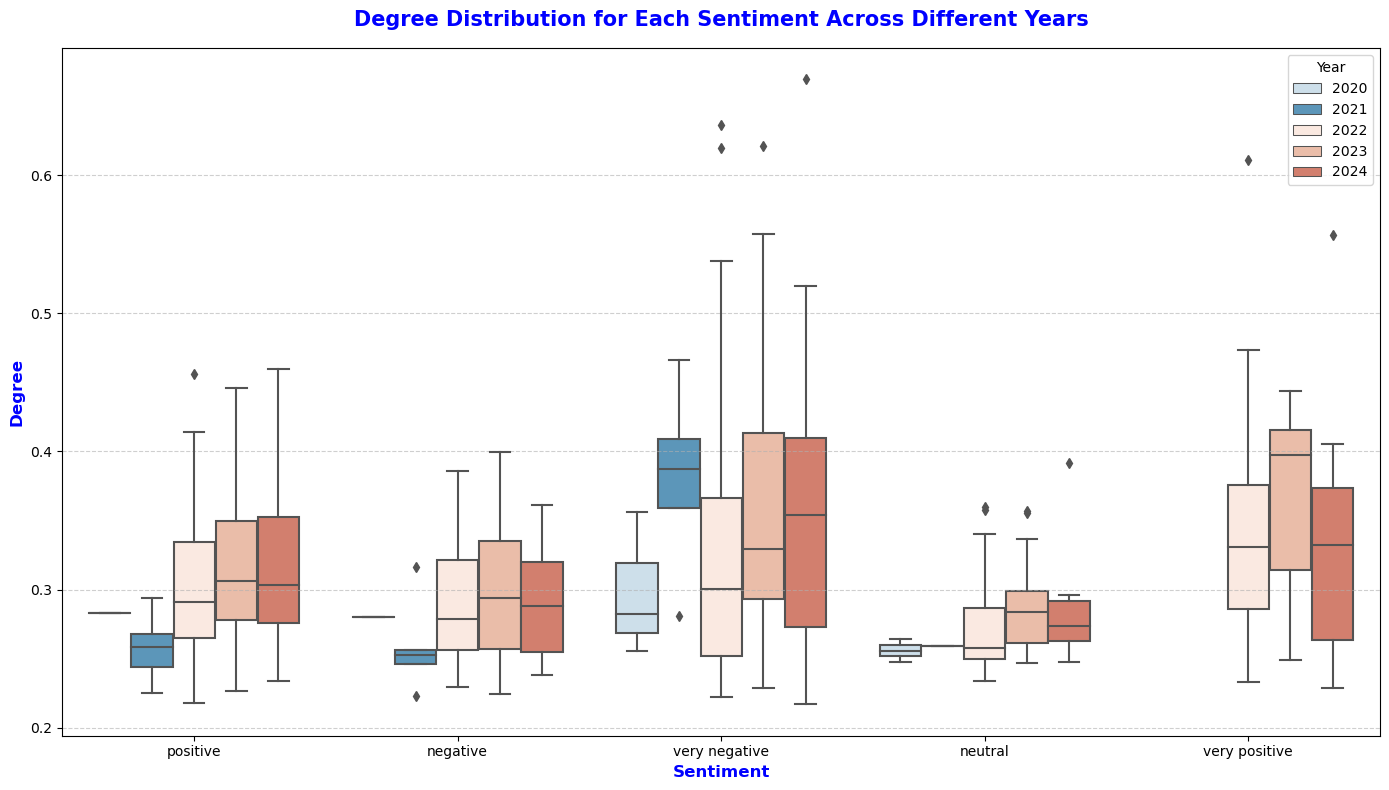

In [ ]:
Sur7 = Sur7.dropna(subset=['Year'])
plt.figure(figsize=(14, 8))

custom_colors = ['#c8e0ef', '#4c9ac9', '#fee8dd', '#f5b99e', '#e2745e']
box = sns.boxplot(x='sentiment', y='degree', hue='Year', data=Sur7, palette=custom_colors)

plt.title('Degree Distribution for Each Sentiment Across Different Years', fontsize=15, color='blue', fontweight='bold', loc='center', pad=16)
plt.xlabel('Sentiment', fontsize=12, color='blue', fontweight='bold')
plt.ylabel('Degree', fontsize=12, color='blue', fontweight='bold')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig('7sur7 Degree.png', dpi=300, bbox_inches='tight')
plt.show()

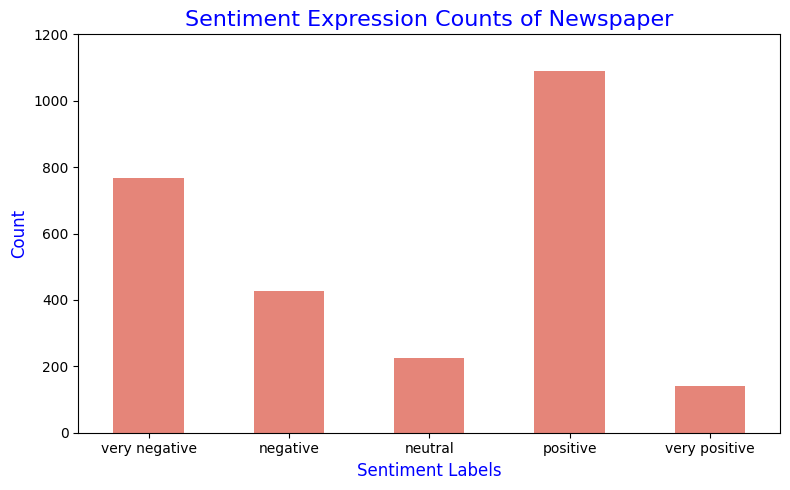

In [ ]:
combined_data = pd.concat([RTNC, Okapi, Actualite, Sur7], ignore_index=True)
sentiments = combined_data['sentiment'].value_counts()
desired_order = ["very negative", "negative", "neutral", "positive", "very positive"]
sentiments = sentiments.reindex(desired_order)

plt.figure(figsize=(8, 5))
sentiments.plot(kind='bar', color='#e58579')
plt.title('Sentiment Expression Counts of Newspaper', fontsize = 16, color = 'blue')
plt.xlabel('Sentiment Labels', fontsize = 12, color = 'blue')
plt.ylabel('Count', fontsize = 12, color = 'blue')
plt.ylim(0, 1200)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('Sentiment Counts.png', dpi=300, bbox_inches='tight')
plt.show()

## Translator

In [1]:
! pip install transformers torch sacremoses
! pip install googletrans==4.0.0-rc1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 43.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.5 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17397 sha256=0e156fa8b0021615221fd9b45799b818911873b77b4f81314a35c5e212fa92ad
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: h11
 

In [2]:
from googletrans import Translator
import time

translator = Translator()

def translate_articles(text, max_length=5000):
    """
    Translate text from French to English.
    If text length exceeds max_length, split it into chunks.
    """
    # Translate directly if the text is within the max_length limit
    if len(text) <= max_length:
        time.sleep(0.5)  # Prevent rate limiting
        translated = translator.translate(text, src='fr', dest='en')
        return translated.text if hasattr(translated, 'text') else text

    # Function to split text into manageable chunks
    def split_text(text, max_length):
        sentences = text.split(". ")  # Split by sentences
        chunks = []
        current_chunk = []
        current_length = 0

        for sentence in sentences:
            if current_length + len(sentence) + 2 > max_length:  # +2 accounts for ". "
                chunks.append(". ".join(current_chunk) + ".")
                current_chunk = []
                current_length = 0
            current_chunk.append(sentence)
            current_length += len(sentence) + 2

        if current_chunk:
            chunks.append(". ".join(current_chunk) + ".")
        return chunks

    # Split the text and translate each chunk
    chunks = split_text(text, max_length)
    translated_chunks = []
    for chunk in chunks:
        time.sleep(0.5)
        translated = translator.translate(chunk, src='fr', dest='en')
        if hasattr(translated, 'text'):
            translated_chunks.append(translated.text)

    return " ".join(translated_chunks)


In [4]:
import pandas as pd

def filter_articles_length(df, column_name):
    """Filters rows where the length of text in the specified column is less than 50."""
    # Ensure column is string type, then filter rows
    df[column_name] = df[column_name].astype(str)  # Convert to string to avoid issues
    return df[df[column_name].str.len() >= 50]

# Load the CSV files
sur7 = pd.read_csv("/content/Extracted_7sur7.csv")
actualite = pd.read_csv("/content/Extracted_Actualite.csv")
okapi = pd.read_csv("/content/Extracted_okapi.csv")
rtnc = pd.read_csv("/content/Extracted_RTNC.csv")

# Filter rows for each DataFrame
sur7 = filter_articles_length(sur7, 'Articles')
actualite = filter_articles_length(actualite, 'Articles')
okapi = filter_articles_length(okapi, 'Articles')
rtnc = filter_articles_length(rtnc, 'Articles')

In [ ]:
rtnc['Translated Articles'] = rtnc['Articles'].apply(translate_articles)
rtnc.head()
# rtnc.to_csv('/content/Translated RTNC.csv', index=False)

,Source,Articles,Year,Translated Articles
0,https://rtnc.cd/nord-kivu-40-presumes-criminel...,Une quarantaine de présumés criminels et 6 arm...,2024,Forty alleged criminals and 6 firearms were pr...
1,https://rtnc.cd/nord-kivu-les-gardiens-de-cout...,Dans une assise tenue ce lundi 30 Septembre 30...,2024,"In a seat held this Monday, September 30, 3024..."
2,https://rtnc.cd/nord-kivu-les-terroristes-du-m...,Le Directeur Balume Hangi de la radio communau...,2024,Balume Hangi director of MWESO Community Radio...
3,https://rtnc.cd/nord-kivu-des-recruteurs-du-m2...,Les services de sécurité en ville de goma ont ...,2024,The security services in the city of Goma anno...
4,https://rtnc.cd/nord-kivu-un-camp-de-transit-e...,Plus de 500 volontaires pour la défense de la ...,2024,More than 500 volunteers for the defense of th...


In [5]:
okapi['Translated Articles'] = okapi['Articles'].apply(translate_articles)
okapi.to_csv('/content/Translated Okapi.csv', index=False)

In [ ]:
actualite['Articles'] = actualite['Articles'].astype(str)
actualite['Translated Articles'] = actualite['Articles'].apply(translate_articles)
actualite.to_csv('/content/Translated Actualite.csv', index=False)

In [ ]:
sur7['Translated Articles'] = sur7['Articles'].apply(translate_articles)
sur7.to_csv('/content/Translated 7sur7.csv', index=False)

## DistilRoberta

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch

device = 0 if torch.cuda.is_available() else -1
tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")
model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/emotion-english-distilroberta-base")
emotion_classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, truncation=True, device=device)

In [ ]:
def classify_emotion(text):
    result = emotion_classifier(text)
    return result[0]['label'], round(result[0]['score'], 3)

In [ ]:
import pandas as pd

rtnc = pd.read_csv("/content/Translated RTNC.csv")
okapi = pd.read_csv("/content/Translated Okapi.csv")
actualite = pd.read_csv("/content/Translated Actualite.csv")
sur7 = pd.read_csv("/content/Translated 7sur7.csv")

In [ ]:
rtnc[['Emotion', 'Score']] = rtnc['Translated Articles'].apply(lambda x: classify_emotion(x)).apply(pd.Series)
# rtnc.to_csv('/content/DistilRoberta RTNC.csv', index=False)

In [ ]:
okapi[['Emotion', 'Score']] = okapi['Translated Articles'].apply(lambda x: classify_emotion(x)).apply(pd.Series)
# okapi.to_csv('/content/DistilRoberta Okapi.csv', index=False)

In [ ]:
actualite[['Emotion', 'Score']] = actualite['Translated Articles'].apply(lambda x: classify_emotion(x)).apply(pd.Series)
# actualite.to_csv('/content/DistilRoberta Actualite.csv', index=False)

In [ ]:
sur7[['Emotion', 'Score']] = sur7['Translated Articles'].apply(lambda x: classify_emotion(x)).apply(pd.Series)
sur7['Year'] = pd.to_datetime(sur7['Year'], format='%Y')
sur7 = sur7.dropna(subset=['Year'])
sur7['Year'] = sur7['Year'].dt.year.astype(int)
# sur7.to_csv('/content/DistilRoberta 7sur7.csv', index=False)

<ipython-input-53-7355fef76bba>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sur7['Year'] = sur7['Year'].dt.year.astype(int)


## DistilBert Visualization


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
rtnc = pd.read_csv("/content/DistilRoberta RTNC.csv")
okapi = pd.read_csv("/content/DistilRoberta Okapi.csv")
actualite = pd.read_csv("/content/DistilRoberta Actualite.csv")
sur7 = pd.read_csv("/content/DistilRoberta 7sur7.csv")

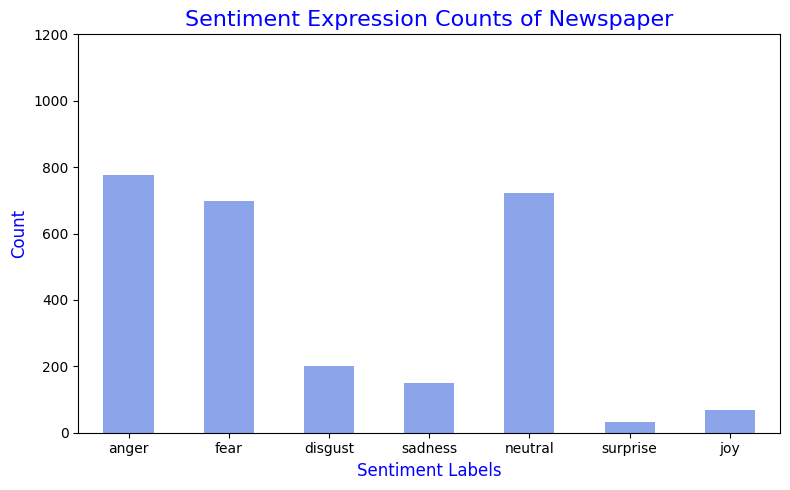

In [9]:
combined_data = pd.concat([rtnc, okapi, actualite, sur7], ignore_index=True)
sentiments = combined_data['Emotion'].value_counts()
desired_order = ["anger", "fear", "disgust", "sadness", "neutral", "surprise", "joy"]
sentiments = sentiments.reindex(desired_order)

plt.figure(figsize=(8, 5))
sentiments.plot(kind='bar', color='#8ca5ea')
plt.title('Sentiment Expression Counts of Newspaper', fontsize = 16, color = 'blue')
plt.xlabel('Sentiment Labels', fontsize = 12, color = 'blue')
plt.ylabel('Count', fontsize = 12, color = 'blue')
plt.ylim(0, 1200)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('Distli Sentiment Counts.png', dpi=300, bbox_inches='tight')
plt.show()

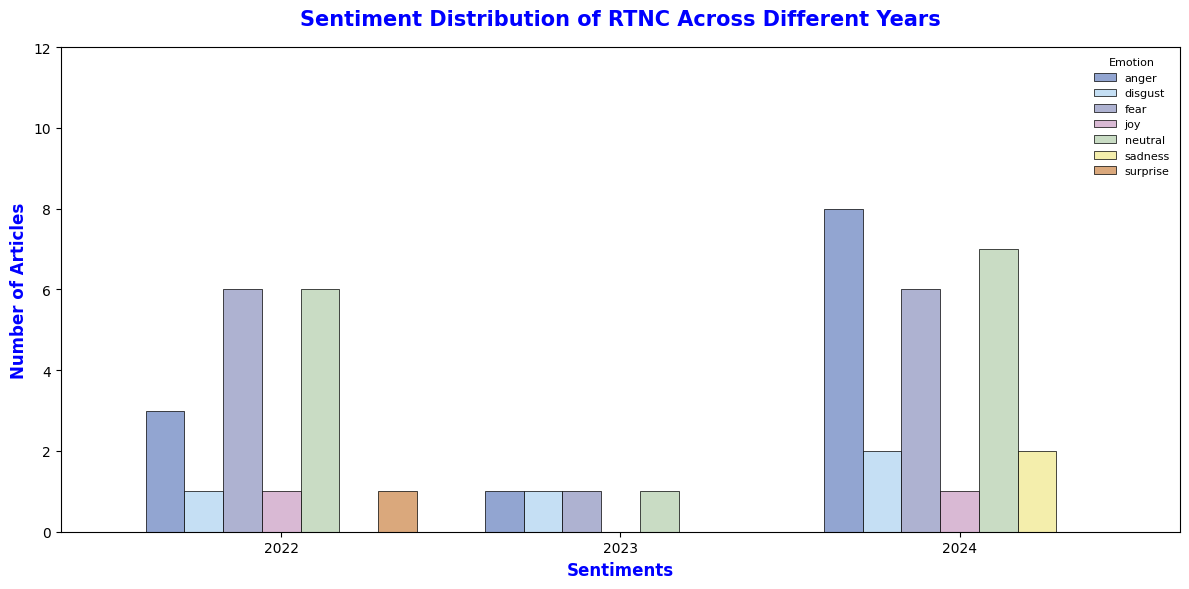

In [ ]:
colors = ['#92a5d1', '#c5dff4', '#aeb2d1', '#d9b9d4','#c9dcc4','#f4eeac','#daa87c']

sentiment_distribution = rtnc.groupby(['Year', 'Emotion']).size().unstack(fill_value=0)
sentiment_distribution.plot(kind='bar', figsize=(12, 6), width=0.8, color = colors, edgecolor='black', linewidth=0.5)

plt.gcf().set_facecolor('white')
plt.gcf().set_edgecolor('blue')
plt.title('Sentiment Distribution of RTNC Across Different Years', fontsize=15, color='blue', fontweight='bold', loc='center', pad=16)
plt.xlabel('Sentiments', fontsize=12, color='blue', fontweight='bold')
plt.ylabel('Number of Articles', fontsize=12, color='blue', fontweight='bold')
plt.xticks(rotation=0)
plt.ylim(0, 12)
plt.legend(title='Emotion', title_fontsize='8', fontsize='8', loc='upper right', frameon=False)
plt.tight_layout()

plt.savefig('DistilBERT RTNC Distribution.png', dpi=300, bbox_inches='tight')
plt.show()

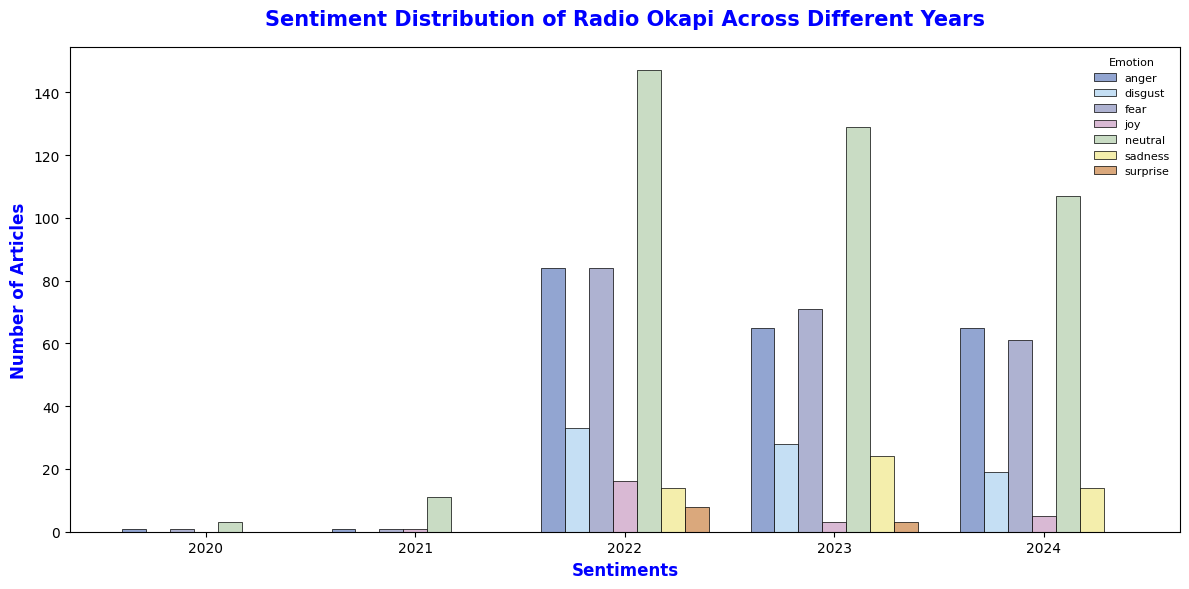

In [ ]:
sentiment_distribution = okapi.groupby(['Year', 'Emotion']).size().unstack(fill_value=0)
sentiment_distribution.plot(kind='bar', figsize=(12, 6), width=0.8, color = colors, edgecolor='black', linewidth=0.5)

plt.gcf().set_facecolor('white')
plt.gcf().set_edgecolor('blue')
plt.title('Sentiment Distribution of Radio Okapi Across Different Years', fontsize=15, color='blue', fontweight='bold', loc='center', pad=16)
plt.xlabel('Sentiments', fontsize=12, color='blue', fontweight='bold')
plt.ylabel('Number of Articles', fontsize=12, color='blue', fontweight='bold')
plt.xticks(rotation=0)
plt.legend(title='Emotion', title_fontsize='8', fontsize='8', loc='upper right', frameon=False)
plt.tight_layout()

plt.savefig('DistilBERT Okapi Distribution.png', dpi=300, bbox_inches='tight')
plt.show()

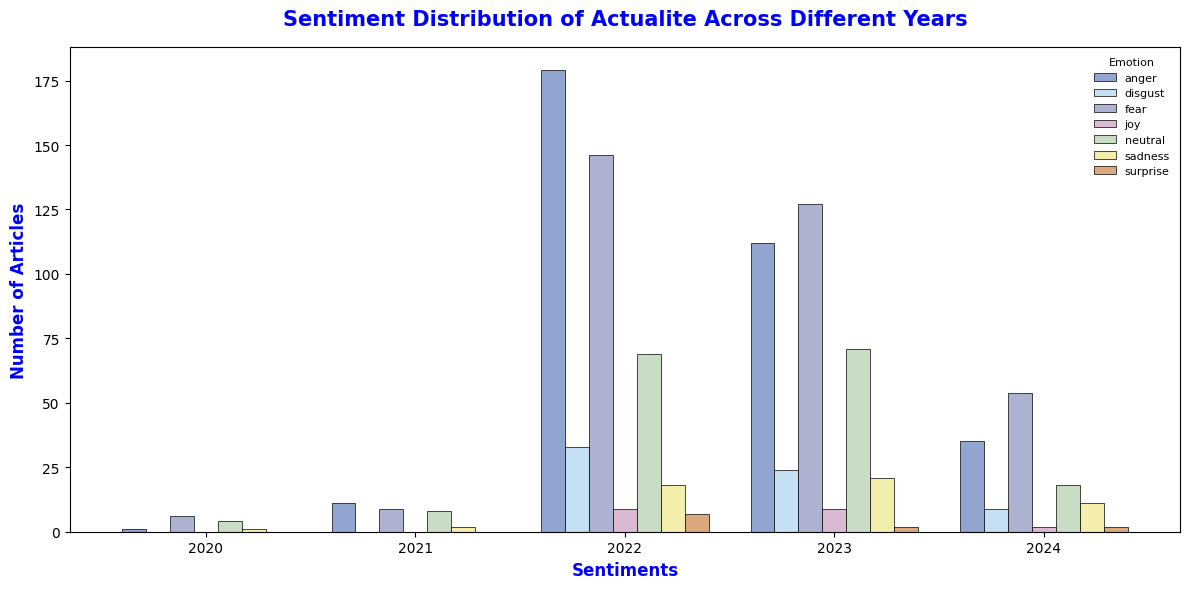

In [ ]:
sentiment_distribution = actualite.groupby(['Year', 'Emotion']).size().unstack(fill_value=0)
sentiment_distribution.plot(kind='bar', figsize=(12, 6), width=0.8, color = colors, edgecolor='black', linewidth=0.5)

plt.gcf().set_facecolor('white')
plt.gcf().set_edgecolor('blue')
plt.title('Sentiment Distribution of Actualite Across Different Years', fontsize=15, color='blue', fontweight='bold', loc='center', pad=16)
plt.xlabel('Sentiments', fontsize=12, color='blue', fontweight='bold')
plt.ylabel('Number of Articles', fontsize=12, color='blue', fontweight='bold')
plt.xticks(rotation=0)
plt.legend(title='Emotion', title_fontsize='8', fontsize='8', loc='upper right', frameon=False)
plt.tight_layout()

plt.savefig('DistilBERT Actualite Distribution.png', dpi=300, bbox_inches='tight')
plt.show()

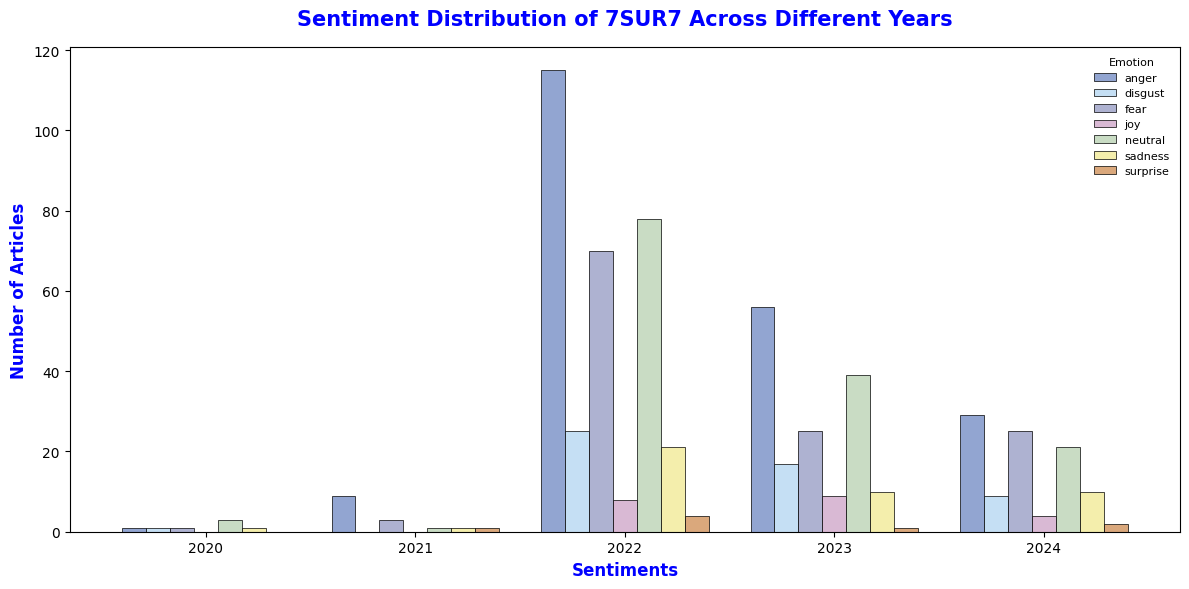

In [ ]:
sentiment_distribution = sur7.groupby(['Year', 'Emotion']).size().unstack(fill_value=0)
sentiment_distribution.plot(kind='bar', figsize=(12, 6), width=0.8, color = colors, edgecolor='black', linewidth=0.5)

plt.gcf().set_facecolor('white')
plt.gcf().set_edgecolor('blue')
plt.title('Sentiment Distribution of 7SUR7 Across Different Years', fontsize=15, color='blue', fontweight='bold', loc='center', pad=16)
plt.xlabel('Sentiments', fontsize=12, color='blue', fontweight='bold')
plt.ylabel('Number of Articles', fontsize=12, color='blue', fontweight='bold')
plt.xticks(rotation=0)
plt.legend(title='Emotion', title_fontsize='8', fontsize='8', loc='upper right', frameon=False)
plt.tight_layout()

plt.savefig('DistilBERT 7SUR7 Distribution.png', dpi=300, bbox_inches='tight')
plt.show()

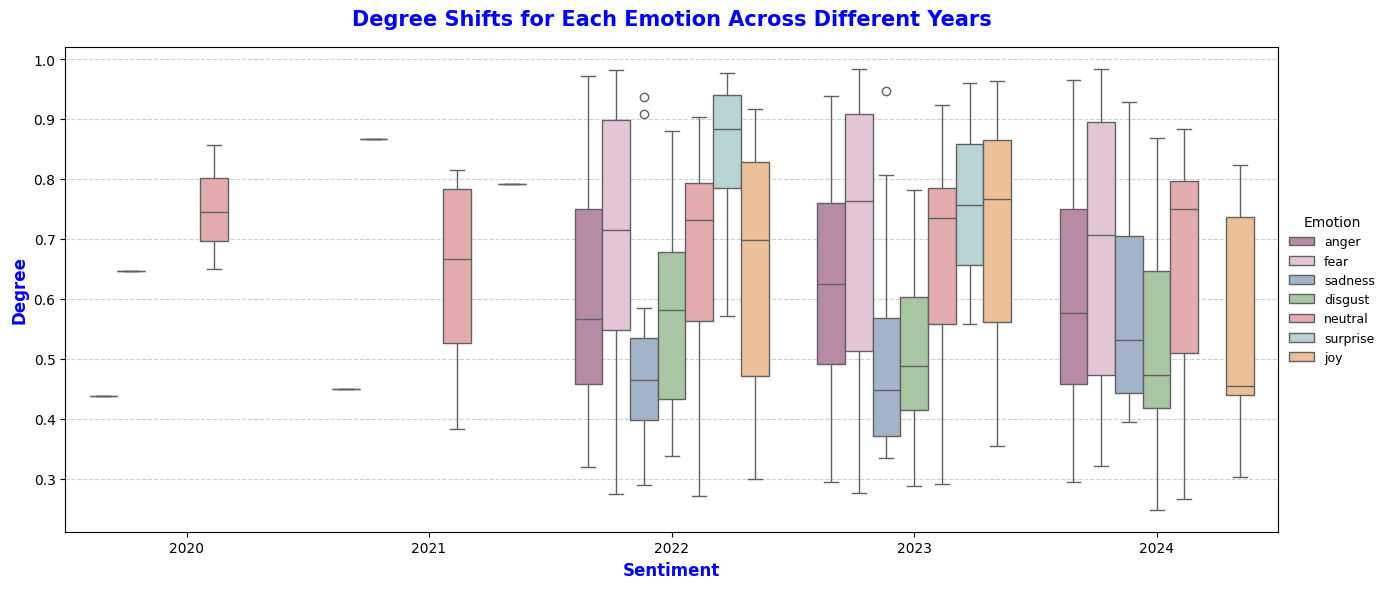

In [ ]:
emotion_order = ['anger', 'fear', 'sadness', 'disgust', 'neutral', 'surprise', 'joy']
palette = ['#bf83a5','#e7c1d7','#9db4ce','#a4cb9e','#eda1a4','#b3d8d5','#f9c08a']

plt.figure(figsize=(14, 6))
box = sns.boxplot(x='Year', y='Score', hue='Emotion', data=okapi, palette=palette, hue_order=emotion_order)

plt.title('Degree Shifts for Each Emotion Across Different Years', fontsize=15, color='blue', fontweight='bold', loc='center', pad=16)
plt.xlabel('Sentiment', fontsize=12, color='blue', fontweight='bold')
plt.ylabel('Degree', fontsize=12, color='blue', fontweight='bold')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Emotion', title_fontsize='10', fontsize='9', loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.tight_layout()

plt.savefig('DistilRoberta Okapi Degree.png', dpi=300, bbox_inches='tight')
plt.show()

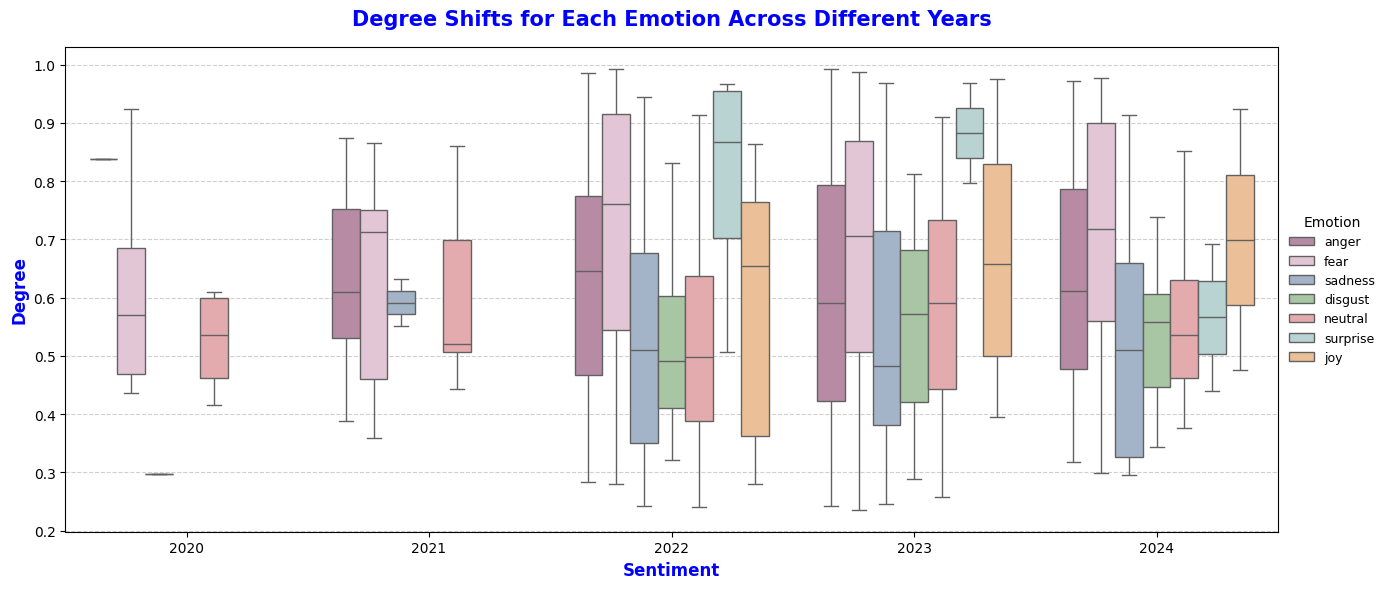

In [ ]:
plt.figure(figsize=(14, 6))

box = sns.boxplot(x='Year', y='Score', hue='Emotion', data=actualite, palette=palette,hue_order=emotion_order)

plt.title('Degree Shifts for Each Emotion Across Different Years', fontsize=15, color='blue', fontweight='bold', loc='center', pad=16)
plt.xlabel('Sentiment', fontsize=12, color='blue', fontweight='bold')
plt.ylabel('Degree', fontsize=12, color='blue', fontweight='bold')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Emotion', title_fontsize='10', fontsize='9', loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.tight_layout()

plt.savefig('DistilRoberta Actualite Degree.png', dpi=300, bbox_inches='tight')
plt.show()

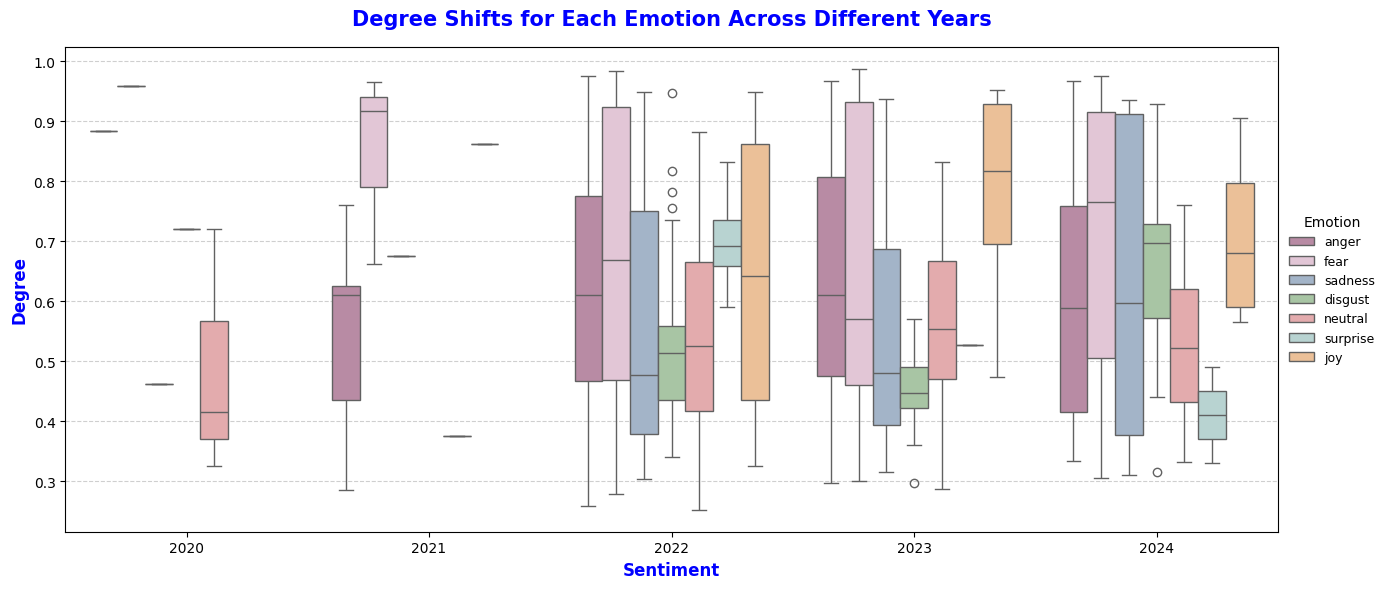

In [ ]:
plt.figure(figsize=(14, 6))

box = sns.boxplot(x='Year', y='Score', hue='Emotion', data=sur7, palette=palette,hue_order=emotion_order)

plt.title('Degree Shifts for Each Emotion Across Different Years', fontsize=15, color='blue', fontweight='bold', loc='center', pad=16)
plt.xlabel('Sentiment', fontsize=12, color='blue', fontweight='bold')
plt.ylabel('Degree', fontsize=12, color='blue', fontweight='bold')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Emotion', title_fontsize='10', fontsize='9', loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.tight_layout()

plt.savefig('DistilRoberta 7SUR7 Degree.png', dpi=300, bbox_inches='tight')
plt.show()

## Key words and Topic Modeling

### TF-IDF

In [7]:
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [12]:
rtnc = pd.read_csv("/content/DistilRoberta RTNC.csv")
okapi = pd.read_csv("/content/DistilRoberta Okapi.csv")
actualite = pd.read_csv("/content/DistilRoberta Actualite.csv")
sur7 = pd.read_csv("/content/DistilRoberta 7sur7.csv")
dataframes = [rtnc, okapi, actualite, sur7]

In [33]:
lemmatizer = WordNetLemmatizer()
custom_stopwords = {'le', 'mer', 'sea', 'sam', 'posted','modified','published'}

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\b\d{1,2}\b', '', text)
    text = re.sub(r'\b20\d{2}\b', '', text)
    words = text.split()
    stop_words = set(stopwords.words('english')).union(custom_stopwords)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word.lower() not in stop_words]
    return ' '.join(lemmatized_words)

for df in dataframes:
    df['Translated Articles'] = df['Translated Articles'].apply(preprocess_text)

In [34]:
def get_top_tfidf_words(df, column_name, top_n=10):
    custom_stopwords = list(set(stopwords.words('english')).union({'le', 'mer', 'sea', 'sam', 'posted', 'modified'}))
    vectorizer = TfidfVectorizer(stop_words=custom_stopwords)
    tfidf_matrix = vectorizer.fit_transform(df[column_name])

    # Sum the TF-IDF scores for each word across all documents
    sum_tfidf = np.array(tfidf_matrix.sum(axis=0)).flatten()

    # Get feature names (words)
    feature_names = vectorizer.get_feature_names_out()

    # Sort words by their TF-IDF score
    top_indices = sum_tfidf.argsort()[-top_n:][::-1]
    top_words = [(feature_names[i], sum_tfidf[i]) for i in top_indices]

    return top_words

In [ ]:
get_top_tfidf_words(rtnc, 'Translated Articles')

[('m23', 2.4659875688905166),
 ('drc', 2.218682885266731),
 ('rwanda', 2.1486184602318175),
 ('state', 1.9176339718993545),
 ('president', 1.9105554510841274),
 ('rwandan', 1.8682204248166727),
 ('goma', 1.7846062384389296),
 ('congolese', 1.6901557247662011),
 ('force', 1.6363977734514403),
 ('press', 1.543242380213136)]

In [35]:
get_top_tfidf_words(okapi, 'Translated Articles')

[('m23', 38.10768584951709),
 ('mar', 37.08351040625243),
 ('drc', 31.351676238277424),
 ('rebel', 27.049157521458397),
 ('congolese', 26.114748214232304),
 ('kivu', 25.08299385947842),
 ('north', 24.667894359258206),
 ('territory', 24.448741066522505),
 ('fardc', 23.113659541868145),
 ('group', 23.066881509925437)]

In [ ]:
get_top_tfidf_words(actualite, 'Translated Articles')

[('m23', 57.509610082418185),
 ('drc', 42.06504620276381),
 ('rwanda', 35.142457997651825),
 ('congolese', 34.589148250875134),
 ('force', 31.26023878074104),
 ('army', 27.923031307185703),
 ('kivu', 27.696091478457696),
 ('armed', 27.588578227937976),
 ('goma', 27.17285236157939),
 ('north', 26.97078258529889)]

In [ ]:
get_top_tfidf_words(sur7, 'Translated Articles')

[('m23', 24.18880679340389),
 ('congolese', 23.953674400189186),
 ('rwanda', 21.39135981248074),
 ('drc', 21.19707233795128),
 ('country', 18.922936512458243),
 ('kivu', 18.61688660862175),
 ('republic', 18.064543851597573),
 ('congo', 17.633504741400504),
 ('president', 17.315578484448686),
 ('north', 16.786987741653505)]

### Latent Semantic Analysis

In [42]:
def get_topics_lsa(df, column_name, n_topics=5, n_top_words=10):
    custom_stopwords = list(set(stopwords.words('english')).union({'le', 'mer','mar' ,'sea', 'sam', 'posted', 'modified','lun',
                                                                   'mon', 'ven', 'pm','dim', 'sun','pub','published'}))
    vectorizer = TfidfVectorizer(stop_words=custom_stopwords)
    tfidf_matrix = vectorizer.fit_transform(df[column_name])
    lsa = TruncatedSVD(n_components=n_topics, random_state=42)
    lsa_matrix = lsa.fit_transform(tfidf_matrix)
    feature_names = vectorizer.get_feature_names_out()

    topics = []
    for topic_idx, component in enumerate(lsa.components_):
        if topic_idx >= 5:
            break
        top_indices = component.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_indices]
        topics.append(top_words)
        print(f"Topic {topic_idx + 1}: {top_words}")
    return None

In [ ]:
get_topics_lsa(rtnc, 'Translated Articles')

Topic 1: ['drc', 'm23', 'rwanda', 'president', 'rwandan', 'congolese', 'state', 'republic', 'united', 'security']
Topic 2: ['national', 'provincial', 'electoral', 'elections', 'january', 'results', 'independent', '14', 'policy', 'commission']
Topic 3: ['goma', 'city', 'fardc', 'terrorists', 'alleged', 'virunga', 'cut', 'electricity', 'mayor', 'army']
Topic 4: ['heads', 'luanda', 'mini', 'process', 'force', 'monusco', 'regional', 'summit', 'eac', 'nairobi']
Topic 5: ['minister', 'defense', 'meeting', 'materials', 'council', 'government', 'restoring', 'part', 'terrorists', 'security']


In [43]:
get_topics_lsa(okapi, 'Translated Articles')

Topic 1: ['m23', 'drc', 'rebel', 'congolese', 'territory', 'kivu', 'north', 'group', 'fardc', 'armed']
Topic 2: ['game', 'enemy', 'call', 'property', 'governor', 'vindictive', 'play', 'compatriot', 'act', 'religious']
Topic 3: ['drc', 'tshisekedi', 'president', 'state', 'rwanda', 'congolese', 'country', 'republic', 'félix', 'peace']
Topic 4: ['people', 'displaced', 'humanitarian', 'monusco', 'population', 'young', 'site', 'kivu', 'beni', 'goma']
Topic 5: ['monusco', 'keita', 'bintou', 'un', 'group', 'armed', 'council', 'united', 'drc', 'humanitarian']


In [ ]:
get_topics_lsa(actualite, 'Translated Articles')

Topic 1: ['m23', 'drc', 'rwanda', 'congolese', 'rebels', 'army', 'armed', 'goma', 'security', 'kivu']
Topic 2: ['goma', 'sake', 'rutshuru', 'clashes', 'city', 'army', 'rebels', 'wazalendo', 'fardc', 'displaced']
Topic 3: ['rwanda', 'rwandan', 'congolese', 'army', 'kigali', 'kinshasa', 'accused', 'tutsi', 'parc', 'afp']
Topic 4: ['force', 'regional', 'eac', 'sadc', 'rebels', 'summit', 'withdrawal', 'm23', 'african', 'troops']
Topic 5: ['siege', 'national', 'state', 'elected', 'government', 'parc', 'des', 'bunagana', 'defense', 'minister']


In [ ]:
get_topics_lsa(sur7, 'Translated Articles')

Topic 1: ['congolese', 'm23', 'rwanda', 'drc', 'kivu', 'country', 'republic', 'army', 'congo', 'force']
Topic 2: ['kivu', 'goma', 'north', 'city', 'army', 'rebel', 'rutshuru', 'territory', 'bunagana', 'clash']
Topic 3: ['regional', 'african', 'luanda', 'eac', 'sadc', 'nairobi', 'community', 'summit', 'deployment', 'ceasefire']
Topic 4: ['rwanda', 'rwandan', 'army', 'fardc', 'kigali', 'kagame', 'congolese', 'soldier', 'congo', 'm23']
Topic 5: ['eac', 'south', 'bukavu', 'regional', 'fayulu', 'martin', 'sadc', 'force', 'city', 'african']


## Statistical Counts

### Multilingual Bert

In [41]:
RTNC.head()

,Source,Articles,Year,sentiment,degree
0,https://rtnc.cd/nord-kivu-40-presumes-criminel...,Une quarantaine de présumés criminels et 6 arm...,2024,positive,0.229060
1,https://rtnc.cd/nord-kivu-les-gardiens-de-cout...,Dans une assise tenue ce lundi 30 Septembre 30...,2024,very negative,0.232342
2,https://rtnc.cd/nord-kivu-les-terroristes-du-m...,Le Directeur Balume Hangi de la radio communau...,2024,very negative,0.356044
3,https://rtnc.cd/nord-kivu-des-recruteurs-du-m2...,Les services de sécurité en ville de goma ont ...,2024,positive,0.363254
4,https://rtnc.cd/nord-kivu-un-camp-de-transit-e...,Plus de 500 volontaires pour la défense de la ...,2024,positive,0.264874


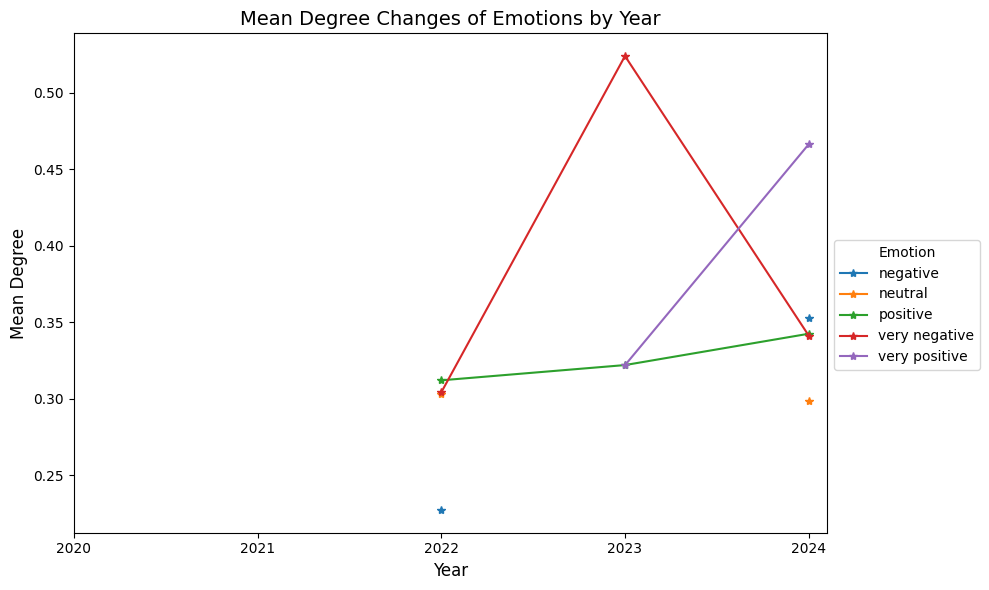

In [43]:
RTNC_degree = RTNC.groupby(['Year', 'sentiment'])['degree'].mean().unstack()

plt.figure(figsize=(10, 6))
for emotion in RTNC_degree.columns:
    plt.plot(RTNC_degree.index, RTNC_degree[emotion], marker='*', label=emotion)

plt.title('Mean Degree Changes of Emotions by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Degree', fontsize=12)
plt.legend(title='Emotion', fontsize=10, bbox_to_anchor=(1, 0.6))
plt.xticks(ticks=range(2020, 2025, 1))
plt.tight_layout()
plt.savefig('Bert RTNC Degree.png', dpi=300, bbox_inches='tight')

plt.show()

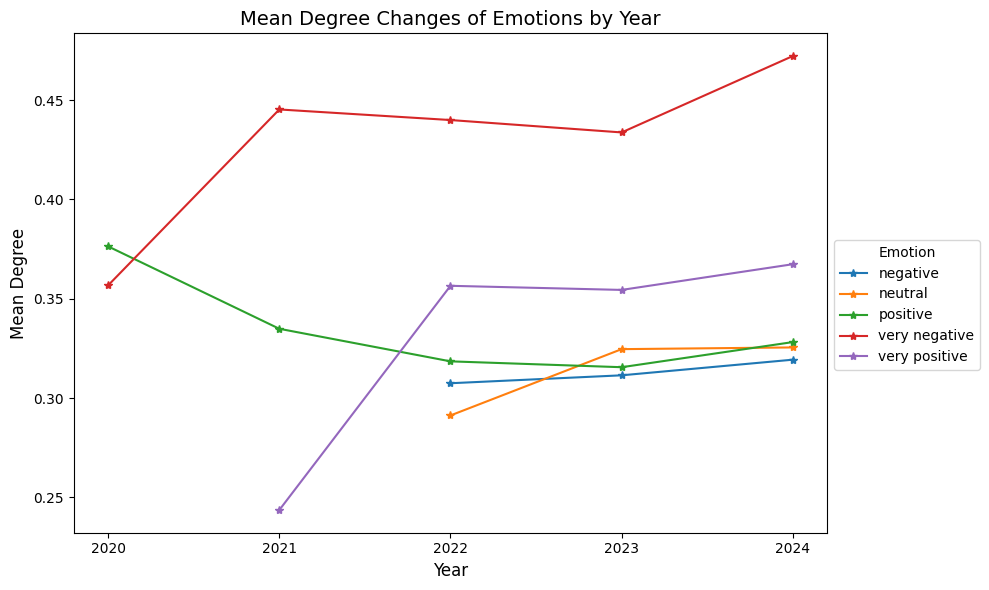

In [44]:
Okapi_degree = Okapi.groupby(['Year', 'sentiment'])['degree'].mean().unstack()

plt.figure(figsize=(10, 6))
for emotion in Okapi_degree.columns:
    plt.plot(Okapi_degree.index, Okapi_degree[emotion], marker='*', label=emotion)

plt.title('Mean Degree Changes of Emotions by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Degree', fontsize=12)
plt.legend(title='Emotion', fontsize=10, bbox_to_anchor=(1, 0.6))
plt.xticks(ticks=range(2020, 2025, 1))
plt.tight_layout()
plt.savefig('Bert Okapi Degree.png', dpi=300, bbox_inches='tight')

plt.show()

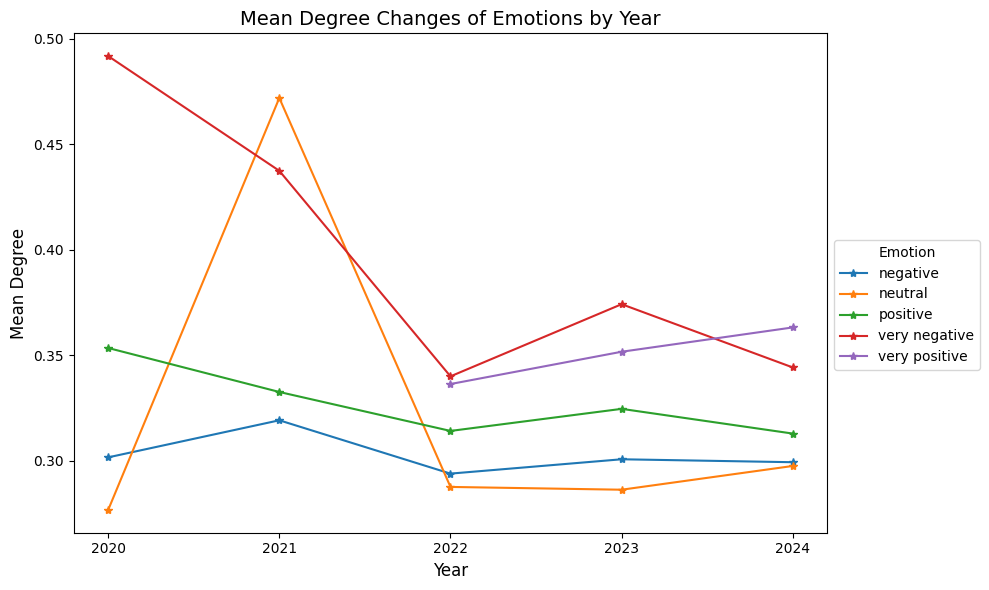

In [45]:
Actualite_degree = Actualite.groupby(['Year', 'sentiment'])['degree'].mean().unstack()

plt.figure(figsize=(10, 6))
for emotion in Actualite_degree.columns:
    plt.plot(Actualite_degree.index, Actualite_degree[emotion], marker='*', label=emotion)

plt.title('Mean Degree Changes of Emotions by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Degree', fontsize=12)
plt.legend(title='Emotion', fontsize=10, bbox_to_anchor=(1, 0.6))
plt.xticks(ticks=range(2020, 2025, 1))
plt.tight_layout()
plt.savefig('Bert Actualite Degree.png', dpi=300, bbox_inches='tight')

plt.show()

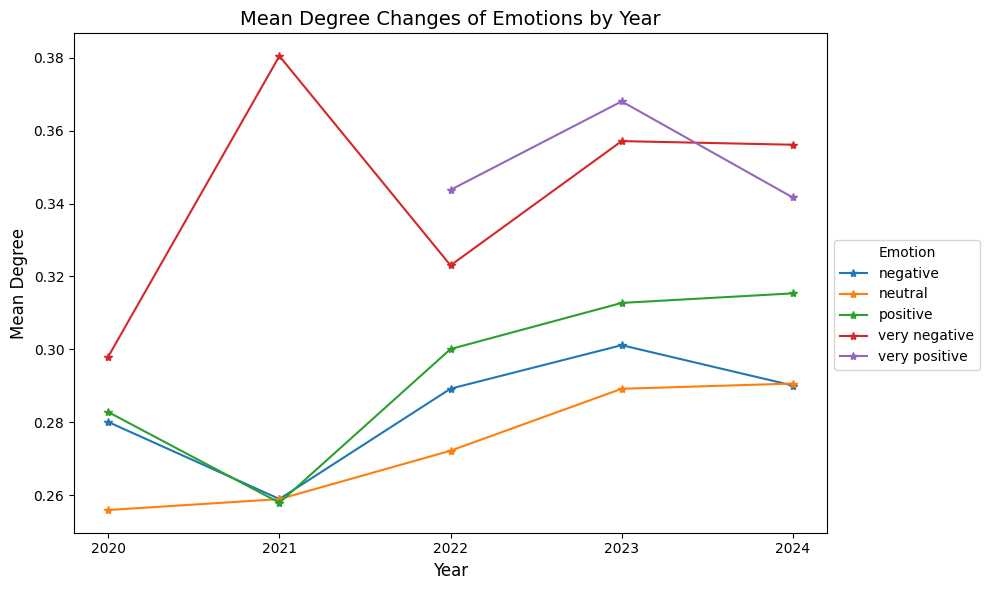

In [49]:
Sur7['Year'] = Sur7['Source'].apply(lambda x: int(re.search(r'/(\d{4})/', x).group(1)) if pd.notna(x) and re.search(r'/(\d{4})/', x) else pd.NA)
Sur_7_score = Sur7.groupby(['Year', 'sentiment'])['degree'].mean().unstack()

plt.figure(figsize=(10, 6))
for emotion in Sur_7_score.columns:
    plt.plot(Sur_7_score.index, Sur_7_score[emotion], marker='*', label=emotion)

plt.title('Mean Degree Changes of Emotions by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Degree', fontsize=12)
plt.legend(title='Emotion', fontsize=10, bbox_to_anchor=(1, 0.6))
plt.xticks(ticks=range(2020, 2025, 1))
plt.tight_layout()
plt.savefig('Bert 7SUR7 Degree.png', dpi=300, bbox_inches='tight')

plt.show()

### DistilRoberta

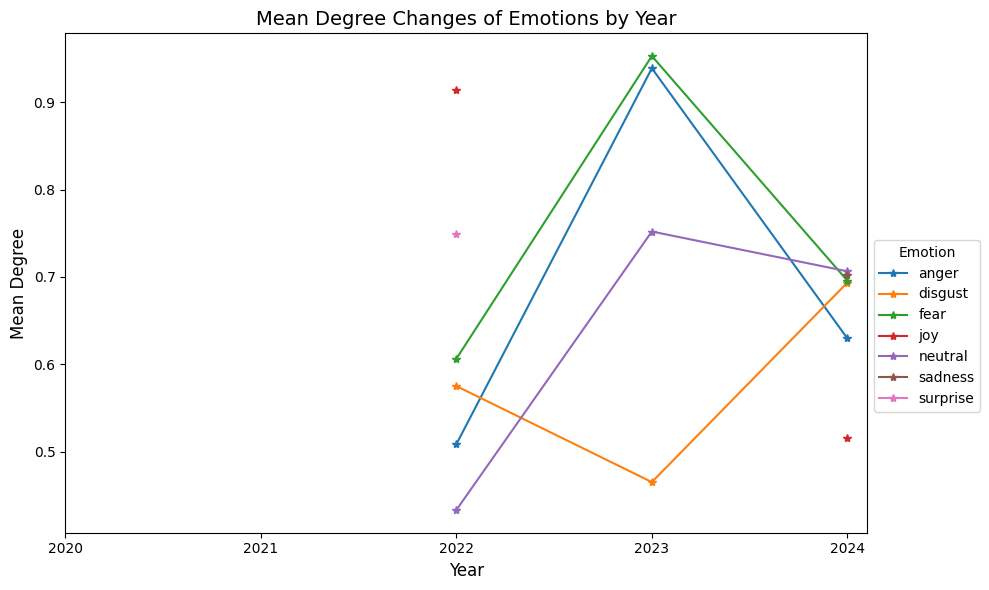

In [34]:
rtnc_score = rtnc.groupby(['Year', 'Emotion'])['Score'].mean().unstack()

plt.figure(figsize=(10, 6))
for emotion in rtnc_score.columns:
    plt.plot(rtnc_score.index, rtnc_score[emotion], marker='*', label=emotion)

plt.title('Mean Degree Changes of Emotions by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Degree', fontsize=12)
plt.legend(title='Emotion', fontsize=10, bbox_to_anchor=(1, 0.6))
plt.xticks(ticks=range(2020, 2025, 1))
plt.tight_layout()
plt.savefig('DistilRoberta RTNC Degree.png', dpi=300, bbox_inches='tight')

plt.show()

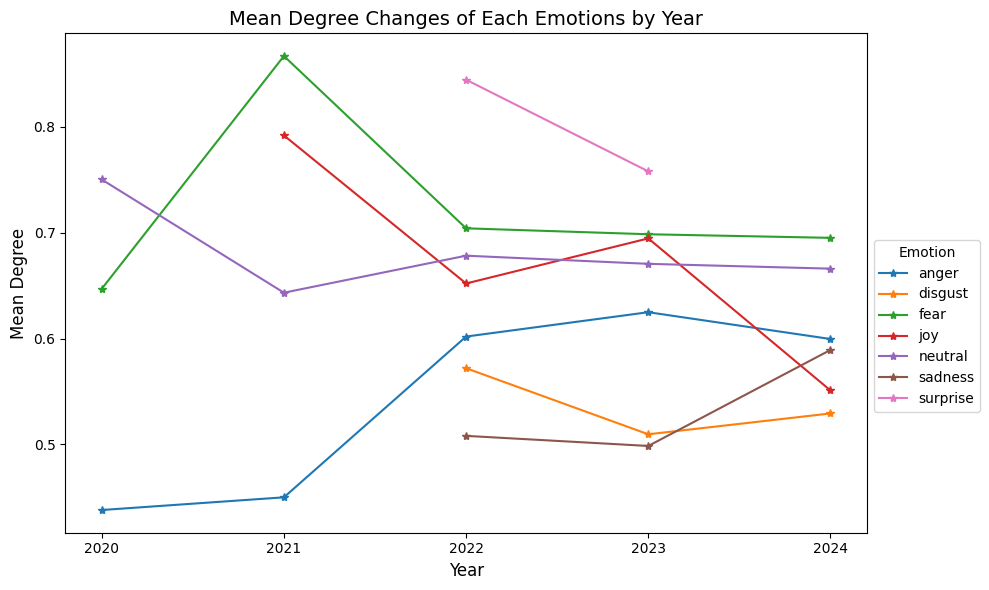

In [35]:
okapi_score = okapi.groupby(['Year', 'Emotion'])['Score'].mean().unstack()

plt.figure(figsize=(10, 6))
for emotion in okapi_score.columns:
    plt.plot(okapi_score.index, okapi_score[emotion], marker='*', label=emotion)

plt.title('Mean Degree Changes of Each Emotions by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Degree', fontsize=12)
plt.legend(title='Emotion', fontsize=10, bbox_to_anchor=(1, 0.6))
plt.xticks(ticks=range(2020, 2025, 1))
plt.tight_layout()
plt.savefig('DistilRoberta Okapi Degree.png', dpi=300, bbox_inches='tight')

plt.show()

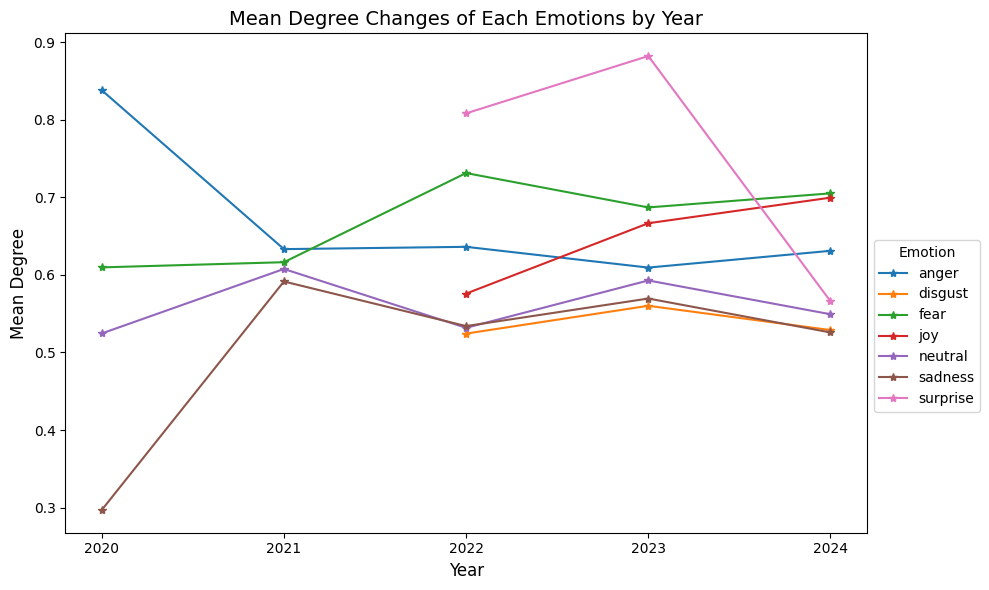

In [36]:
actualite_score = actualite.groupby(['Year', 'Emotion'])['Score'].mean().unstack()

plt.figure(figsize=(10, 6))
for emotion in actualite_score.columns:
    plt.plot(actualite_score.index, actualite_score[emotion], marker='*', label=emotion)

plt.title('Mean Degree Changes of Each Emotions by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Degree', fontsize=12)
plt.legend(title='Emotion', fontsize=10, bbox_to_anchor=(1, 0.6))
plt.xticks(ticks=range(2020, 2025, 1))
plt.tight_layout()
plt.savefig('DistilRoberta Actualite Degree.png', dpi=300, bbox_inches='tight')

plt.show()

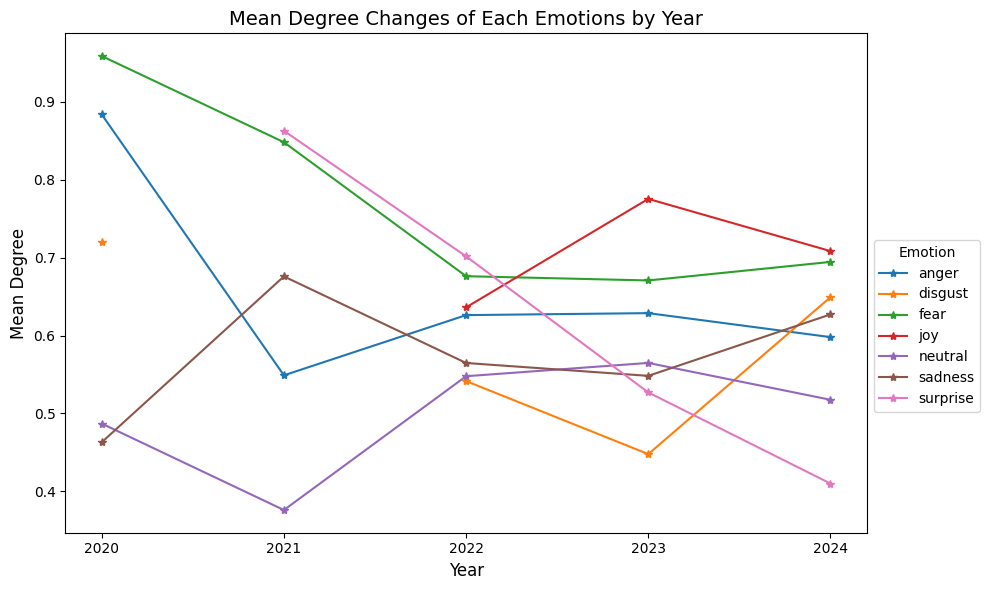

In [37]:
sur7_score = sur7.groupby(['Year', 'Emotion'])['Score'].mean().unstack()

plt.figure(figsize=(10, 6))
for emotion in sur7_score.columns:
    plt.plot(sur7_score.index, sur7_score[emotion], marker='*', label=emotion)

plt.title('Mean Degree Changes of Each Emotions by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Degree', fontsize=12)
plt.legend(title='Emotion', fontsize=10, bbox_to_anchor=(1, 0.6))
plt.xticks(ticks=range(2020, 2025, 1))
plt.tight_layout()
plt.savefig('DistilRoberta 7SUR7 Degree.png', dpi=300, bbox_inches='tight')

plt.show()

## Statistical Results

In [52]:
RTNC.groupby(['Year', 'sentiment'])['degree'].describe()

count      mean       std       min       25%       50%  \
Year sentiment                                                                
2022 negative         1.0  0.227165       NaN  0.227165  0.227165  0.227165   
     neutral          2.0  0.302910  0.031179  0.280863  0.291887  0.302910   
     positive         9.0  0.311933  0.047497  0.268750  0.278376  0.291441   
     very negative    6.0  0.304078  0.040103  0.269265  0.276008  0.291121   
2023 positive         2.0  0.321895  0.058747  0.280355  0.301125  0.321895   
     very negative    1.0  0.523857       NaN  0.523857  0.523857  0.523857   
     very positive    1.0  0.321814       NaN  0.321814  0.321814  0.321814   
2024 negative         1.0  0.352944       NaN  0.352944  0.352944  0.352944   
     neutral          3.0  0.298124  0.016756  0.288449  0.288449  0.288449   
     positive        11.0  0.342360  0.081644  0.229060  0.278606  0.326008   
     very negative    9.0  0.341198  0.123009  0.227896  0.253818  0.305009   
     very positive    2.0  0.466176  0.019591  0.452323  0.459249  0.466176   

                         75%       max  
Year sentiment                          
2022 negative       0.227165  0.227165  
     neutral        0.313934  0.324957  
     positive       0.343369  0.412900  
     very negative  0.318496  0.374370  
2023 positive       0.342666  0.363436  
     very negative  0.523857  0.523857  
     very positive  0.321814  0.321814  
2024 negative       0.352944  0.352944  
     neutral        0.302961  0.317472  
     positive       0.427552  0.443906  
     very negative  0.356044  0.619036  
     very positive  0.473102  0.480028

In [55]:
Okapi.groupby(['Year', 'sentiment'])['degree'].describe()

count      mean       std       min       25%       50%  \
Year sentiment                                                                
2020 positive         2.0  0.376374  0.055603  0.337056  0.356715  0.376374   
     very negative    3.0  0.356751  0.084137  0.305000  0.308210  0.311421   
2021 positive         6.0  0.334881  0.044082  0.279071  0.311061  0.324713   
     very negative    7.0  0.445354  0.148197  0.273999  0.296913  0.536389   
     very positive    1.0  0.243587       NaN  0.243587  0.243587  0.243587   
2022 negative        32.0  0.307447  0.072532  0.225315  0.257234  0.296357   
     neutral         37.0  0.291225  0.039076  0.235322  0.264054  0.282752   
     positive       149.0  0.318471  0.063121  0.222852  0.267480  0.307459   
     very negative  140.0  0.440023  0.126433  0.229345  0.316365  0.480058   
     very positive   29.0  0.356528  0.099714  0.236899  0.278584  0.343286   
2023 negative        52.0  0.311439  0.073172  0.225229  0.258737  0.290325   
     neutral         35.0  0.324622  0.079670  0.227452  0.261126  0.301948   
     positive       110.0  0.315521  0.052847  0.219328  0.275422  0.312691   
     very negative  111.0  0.433783  0.112732  0.223523  0.323722  0.475970   
     very positive   15.0  0.354455  0.071289  0.259066  0.296705  0.334326   
2024 negative        35.0  0.319311  0.076483  0.229058  0.251697  0.304150   
     neutral         19.0  0.325482  0.066627  0.230741  0.280109  0.307619   
     positive       106.0  0.328176  0.055488  0.221062  0.292290  0.321821   
     very negative   96.0  0.472264  0.111238  0.235105  0.410337  0.517002   
     very positive   15.0  0.367402  0.079310  0.260925  0.304960  0.343088   

                         75%       max  
Year sentiment                          
2020 positive       0.396032  0.415691  
     very negative  0.382627  0.453834  
2021 positive       0.362001  0.399849  
     very negative  0.553192  0.606881  
     very positive  0.243587  0.243587  
2022 negative       0.321926  0.544051  
     neutral        0.312705  0.409437  
     positive       0.360246  0.512791  
     very negative  0.551993  0.779392  
     very positive  0.416112  0.737916  
2023 negative       0.355874  0.553427  
     neutral        0.371427  0.524095  
     positive       0.353741  0.460711  
     very negative  0.536086  0.598744  
     very positive  0.397744  0.504320  
2024 negative       0.376149  0.537254  
     neutral        0.371043  0.475642  
     positive       0.367039  0.484906  
     very negative  0.542268  0.739683  
     very positive  0.414548  0.515511

In [57]:
Actualite.groupby(['Year', 'sentiment'])['degree'].describe()

count      mean       std       min       25%       50%  \
Year sentiment                                                                
2020 negative         1.0  0.301689       NaN  0.301689  0.301689  0.301689   
     neutral          2.0  0.276749  0.005987  0.272515  0.274632  0.276749   
     positive         7.0  0.353501  0.080269  0.262962  0.291091  0.344058   
     very negative    2.0  0.491786  0.037703  0.465125  0.478456  0.491786   
2021 negative         7.0  0.319251  0.054929  0.262282  0.280756  0.292936   
     neutral          1.0  0.471916       NaN  0.471916  0.471916  0.471916   
     positive        13.0  0.332663  0.073226  0.240420  0.289869  0.309694   
     very negative    9.0  0.437424  0.189246  0.237453  0.317821  0.328628   
2022 negative        86.0  0.293995  0.050860  0.233053  0.255640  0.280023   
     neutral         32.0  0.287687  0.047260  0.221015  0.263537  0.282113   
     positive       203.0  0.314210  0.057526  0.214952  0.268424  0.309041   
     very negative  118.0  0.340068  0.077083  0.226062  0.275591  0.330242   
     very positive   22.0  0.336423  0.067288  0.232738  0.276723  0.337726   
2023 negative        93.0  0.300786  0.056869  0.222386  0.260932  0.284160   
     neutral         24.0  0.286368  0.030867  0.232180  0.269320  0.281769   
     positive       168.0  0.324667  0.057406  0.220827  0.277129  0.323515   
     very negative   75.0  0.374241  0.110051  0.239271  0.304224  0.341654   
     very positive    6.0  0.351717  0.026928  0.324501  0.331408  0.343577   
2024 negative        27.0  0.299392  0.058846  0.230815  0.265966  0.292455   
     neutral          9.0  0.297617  0.024025  0.254703  0.285688  0.295403   
     positive        67.0  0.312954  0.052023  0.225425  0.272719  0.305292   
     very negative   24.0  0.344269  0.107126  0.239188  0.264179  0.326338   
     very positive    4.0  0.363240  0.052580  0.309599  0.323203  0.362996   

                         75%       max  
Year sentiment                          
2020 negative       0.301689  0.301689  
     neutral        0.278866  0.280983  
     positive       0.399260  0.486786  
     very negative  0.505116  0.518446  
2021 negative       0.358206  0.401614  
     neutral        0.471916  0.471916  
     positive       0.366408  0.505981  
     very negative  0.612805  0.716912  
2022 negative       0.328465  0.435430  
     neutral        0.292241  0.473911  
     positive       0.347743  0.501288  
     very negative  0.382198  0.591537  
     very positive  0.361197  0.492045  
2023 negative       0.335896  0.565712  
     neutral        0.311663  0.355130  
     positive       0.360732  0.469208  
     very negative  0.404292  0.716912  
     very positive  0.373293  0.388098  
2024 negative       0.317270  0.530693  
     neutral        0.313322  0.333133  
     positive       0.348079  0.440782  
     very negative  0.409880  0.678490  
     very positive  0.403034  0.417369

In [58]:
Sur7.groupby(['Year', 'sentiment'])['degree'].describe()

count      mean       std       min       25%       50%  \
Year sentiment                                                                
2020 negative         1.0  0.280116       NaN  0.280116  0.280116  0.280116   
     neutral          2.0  0.255991  0.011595  0.247792  0.251891  0.255991   
     positive         1.0  0.282840       NaN  0.282840  0.282840  0.282840   
     very negative    3.0  0.298042  0.052369  0.255466  0.268803  0.282141   
2021 negative         5.0  0.259010  0.034430  0.223238  0.246159  0.252895   
     neutral          1.0  0.258980       NaN  0.258980  0.258980  0.258980   
     positive         5.0  0.257978  0.025801  0.225094  0.244203  0.258624   
     very negative    4.0  0.380429  0.076149  0.280854  0.358845  0.387277   
2022 negative        48.0  0.289249  0.041377  0.229262  0.256534  0.278908   
     neutral         35.0  0.272253  0.032430  0.234112  0.250035  0.257677   
     positive       131.0  0.300116  0.047751  0.217869  0.265141  0.290820   
     very negative   82.0  0.323052  0.087348  0.222545  0.252156  0.300185   
     very positive   25.0  0.343745  0.085245  0.233118  0.286022  0.330900   
2023 negative        25.0  0.301172  0.049369  0.224359  0.257017  0.293950   
     neutral         18.0  0.289223  0.035009  0.247289  0.261605  0.283724   
     positive        56.0  0.312756  0.049027  0.226391  0.277982  0.306599   
     very negative   46.0  0.357109  0.100750  0.229119  0.293106  0.329200   
     very positive   13.0  0.367996  0.065529  0.249270  0.314275  0.397636   
2024 negative        12.0  0.290118  0.042911  0.238202  0.254631  0.288408   
     neutral          6.0  0.290656  0.052147  0.247867  0.263029  0.273515   
     positive        43.0  0.315377  0.055001  0.233885  0.275992  0.303194   
     very negative   31.0  0.356117  0.104134  0.216946  0.272804  0.354207   
     very positive    8.0  0.341654  0.105954  0.229092  0.263843  0.331971   

                         75%       max  
Year sentiment                          
2020 negative       0.280116  0.280116  
     neutral        0.260090  0.264190  
     positive       0.282840  0.282840  
     very negative  0.319329  0.356518  
2021 negative       0.256705  0.316056  
     neutral        0.258980  0.258980  
     positive       0.268091  0.293880  
     very negative  0.408861  0.466308  
2022 negative       0.321791  0.386219  
     neutral        0.286738  0.359776  
     positive       0.334593  0.456397  
     very negative  0.366398  0.636225  
     very positive  0.375883  0.610905  
2023 negative       0.335090  0.399415  
     neutral        0.298977  0.356754  
     positive       0.349803  0.445992  
     very negative  0.413173  0.620844  
     very positive  0.415469  0.443783  
2024 negative       0.320211  0.361122  
     neutral        0.291670  0.391783  
     positive       0.352665  0.459648  
     very negative  0.410070  0.669130  
     very positive  0.373365  0.556834

In [59]:
rtnc.groupby(['Year', 'Emotion'])['Score'].describe()

count      mean       std    min      25%     50%      75%  \
Year Emotion                                                                
2022 anger       3.0  0.508333  0.010017  0.498  0.50350  0.5090  0.51350   
     disgust     1.0  0.575000       NaN  0.575  0.57500  0.5750  0.57500   
     fear        6.0  0.606167  0.257994  0.370  0.39100  0.5315  0.80325   
     joy         1.0  0.914000       NaN  0.914  0.91400  0.9140  0.91400   
     neutral     6.0  0.433000  0.164072  0.238  0.34875  0.4145  0.46600   
     surprise    1.0  0.749000       NaN  0.749  0.74900  0.7490  0.74900   
2023 anger       1.0  0.939000       NaN  0.939  0.93900  0.9390  0.93900   
     disgust     1.0  0.465000       NaN  0.465  0.46500  0.4650  0.46500   
     fear        1.0  0.953000       NaN  0.953  0.95300  0.9530  0.95300   
     neutral     1.0  0.752000       NaN  0.752  0.75200  0.7520  0.75200   
2024 anger       8.0  0.629625  0.236203  0.303  0.42875  0.6525  0.75125   
     disgust     2.0  0.693500  0.392444  0.416  0.55475  0.6935  0.83225   
     fear        6.0  0.695667  0.165793  0.448  0.60075  0.7130  0.80875   
     joy         1.0  0.515000       NaN  0.515  0.51500  0.5150  0.51500   
     neutral     7.0  0.706429  0.172776  0.401  0.63850  0.7520  0.78150   
     sadness     2.0  0.702500  0.275065  0.508  0.60525  0.7025  0.79975   

                 max  
Year Emotion          
2022 anger     0.518  
     disgust   0.575  
     fear      0.966  
     joy       0.914  
     neutral   0.721  
     surprise  0.749  
2023 anger     0.939  
     disgust   0.465  
     fear      0.953  
     neutral   0.752  
2024 anger     0.977  
     disgust   0.971  
     fear      0.896  
     joy       0.515  
     neutral   0.952  
     sadness   0.897

In [60]:
okapi.groupby(['Year', 'Emotion'])['Score'].describe()

count      mean       std    min      25%     50%      75%  \
Year Emotion                                                                
2020 anger       1.0  0.438000       NaN  0.438  0.43800  0.4380  0.43800   
     fear        1.0  0.647000       NaN  0.647  0.64700  0.6470  0.64700   
     neutral     3.0  0.750333  0.104103  0.649  0.69700  0.7450  0.80100   
2021 anger       1.0  0.450000       NaN  0.450  0.45000  0.4500  0.45000   
     fear        1.0  0.867000       NaN  0.867  0.86700  0.8670  0.86700   
     joy         1.0  0.792000       NaN  0.792  0.79200  0.7920  0.79200   
     neutral    11.0  0.643364  0.161179  0.383  0.52700  0.6670  0.78250   
2022 anger      84.0  0.601917  0.192185  0.320  0.45700  0.5665  0.75050   
     disgust    33.0  0.572000  0.166368  0.338  0.43300  0.5820  0.67800   
     fear       84.0  0.704190  0.208917  0.274  0.54850  0.7145  0.89850   
     joy        16.0  0.652062  0.205562  0.300  0.47125  0.6975  0.82900   
     neutral   147.0  0.678333  0.150549  0.271  0.56250  0.7310  0.79350   
     sadness    14.0  0.508071  0.192712  0.290  0.39850  0.4645  0.53375   
     surprise    8.0  0.844625  0.134061  0.571  0.78525  0.8825  0.94000   
2023 anger      65.0  0.624923  0.172088  0.295  0.49100  0.6250  0.75900   
     disgust    28.0  0.509571  0.131696  0.287  0.41400  0.4875  0.60250   
     fear       71.0  0.698592  0.218846  0.276  0.51200  0.7630  0.90800   
     joy         3.0  0.694667  0.310877  0.354  0.56050  0.7670  0.86500   
     neutral   129.0  0.670636  0.159249  0.291  0.55800  0.7340  0.78500   
     sadness    24.0  0.498542  0.151883  0.335  0.37150  0.4475  0.56850   
     surprise    3.0  0.758000  0.201007  0.558  0.65700  0.7560  0.85800   
2024 anger      65.0  0.599600  0.184357  0.294  0.45800  0.5770  0.75000   
     disgust    19.0  0.529263  0.170344  0.248  0.41700  0.4720  0.64550   
     fear       61.0  0.695197  0.217540  0.321  0.47300  0.7070  0.89500   
     joy         5.0  0.551000  0.219055  0.302  0.44000  0.4540  0.73600   
     neutral   107.0  0.666084  0.167752  0.266  0.51000  0.7500  0.79650   
     sadness    14.0  0.589286  0.173295  0.395  0.44250  0.5320  0.70550   

                 max  
Year Emotion          
2020 anger     0.438  
     fear      0.647  
     neutral   0.857  
2021 anger     0.450  
     fear      0.867  
     joy       0.792  
     neutral   0.815  
2022 anger     0.971  
     disgust   0.880  
     fear      0.982  
     joy       0.917  
     neutral   0.904  
     sadness   0.936  
     surprise  0.976  
2023 anger     0.938  
     disgust   0.782  
     fear      0.983  
     joy       0.963  
     neutral   0.923  
     sadness   0.946  
     surprise  0.960  
2024 anger     0.965  
     disgust   0.868  
     fear      0.983  
     joy       0.823  
     neutral   0.883  
     sadness   0.929

In [61]:
actualite.groupby(['Year', 'Emotion'])['Score'].describe()

count      mean       std    min      25%     50%      75%  \
Year Emotion                                                                
2020 anger       1.0  0.838000       NaN  0.838  0.83800  0.8380  0.83800   
     fear        6.0  0.609667  0.187850  0.436  0.46950  0.5695  0.68450   
     neutral     4.0  0.524500  0.093646  0.416  0.46175  0.5360  0.59875   
     sadness     1.0  0.297000       NaN  0.297  0.29700  0.2970  0.29700   
2021 anger      11.0  0.633182  0.173115  0.388  0.53150  0.6100  0.75150   
     fear        9.0  0.616333  0.191609  0.359  0.46100  0.7130  0.75000   
     neutral     8.0  0.607625  0.166101  0.444  0.50625  0.5205  0.69900   
     sadness     2.0  0.591500  0.057276  0.551  0.57125  0.5915  0.61175   
2022 anger     179.0  0.636140  0.188722  0.283  0.46750  0.6460  0.77500   
     disgust    33.0  0.524333  0.155042  0.321  0.41100  0.4920  0.60200   
     fear      146.0  0.731199  0.207008  0.280  0.54400  0.7615  0.91600   
     joy         9.0  0.575889  0.229395  0.280  0.36300  0.6540  0.76400   
     neutral    69.0  0.531783  0.175465  0.241  0.38900  0.4980  0.63700   
     sadness    18.0  0.534000  0.215963  0.243  0.35050  0.5105  0.67650   
     surprise    7.0  0.808143  0.186382  0.507  0.70250  0.8670  0.95550   
2023 anger     112.0  0.609402  0.202199  0.243  0.42275  0.5910  0.79350   
     disgust    24.0  0.560167  0.165496  0.288  0.42150  0.5715  0.68175   
     fear      127.0  0.686913  0.201704  0.236  0.50600  0.7060  0.86800   
     joy         9.0  0.666556  0.196917  0.395  0.50000  0.6580  0.82900   
     neutral    71.0  0.592817  0.181848  0.257  0.44300  0.5900  0.73250   
     sadness    21.0  0.569524  0.233636  0.245  0.38200  0.4820  0.71500   
     surprise    2.0  0.882000  0.121622  0.796  0.83900  0.8820  0.92500   
2024 anger      35.0  0.631000  0.186245  0.318  0.47750  0.6120  0.78700   
     disgust     9.0  0.528889  0.120335  0.343  0.44700  0.5580  0.60600   
     fear       54.0  0.705037  0.198279  0.299  0.56025  0.7170  0.89900   
     joy         2.0  0.699500  0.316077  0.476  0.58775  0.6995  0.81125   
     neutral    18.0  0.549278  0.125084  0.376  0.46150  0.5350  0.63000   
     sadness    11.0  0.525818  0.235001  0.296  0.32650  0.5100  0.66000   
     surprise    2.0  0.566000  0.178191  0.440  0.50300  0.5660  0.62900   

                 max  
Year Emotion          
2020 anger     0.838  
     fear      0.924  
     neutral   0.610  
     sadness   0.297  
2021 anger     0.874  
     fear      0.866  
     neutral   0.861  
     sadness   0.632  
2022 anger     0.985  
     disgust   0.831  
     fear      0.992  
     joy       0.863  
     neutral   0.914  
     sadness   0.944  
     surprise  0.967  
2023 anger     0.992  
     disgust   0.813  
     fear      0.988  
     joy       0.975  
     neutral   0.910  
     sadness   0.969  
     surprise  0.968  
2024 anger     0.972  
     disgust   0.738  
     fear      0.977  
     joy       0.923  
     neutral   0.851  
     sadness   0.913  
     surprise  0.692

In [62]:
sur7.groupby(['Year', 'Emotion'])['Score'].describe()

count      mean       std    min      25%     50%      75%  \
Year Emotion                                                                
2020 anger       1.0  0.884000       NaN  0.884  0.88400  0.8840  0.88400   
     disgust     1.0  0.720000       NaN  0.720  0.72000  0.7200  0.72000   
     fear        1.0  0.959000       NaN  0.959  0.95900  0.9590  0.95900   
     neutral     3.0  0.487000  0.207586  0.325  0.37000  0.4150  0.56800   
     sadness     1.0  0.463000       NaN  0.463  0.46300  0.4630  0.46300   
2021 anger       9.0  0.549000  0.141678  0.286  0.43500  0.6100  0.62500   
     fear        3.0  0.848333  0.163072  0.662  0.79000  0.9180  0.94150   
     neutral     1.0  0.376000       NaN  0.376  0.37600  0.3760  0.37600   
     sadness     1.0  0.676000       NaN  0.676  0.67600  0.6760  0.67600   
     surprise    1.0  0.863000       NaN  0.863  0.86300  0.8630  0.86300   
2022 anger     115.0  0.626296  0.189493  0.259  0.46800  0.6100  0.77500   
     disgust    25.0  0.541600  0.153425  0.341  0.43500  0.5140  0.55900   
     fear       70.0  0.676271  0.223605  0.279  0.46975  0.6685  0.92325   
     joy         8.0  0.636250  0.246844  0.326  0.43550  0.6420  0.86325   
     neutral    78.0  0.547833  0.178788  0.253  0.41775  0.5265  0.66575   
     sadness    21.0  0.564810  0.223129  0.304  0.37900  0.4770  0.75000   
     surprise    4.0  0.701750  0.099436  0.591  0.65850  0.6920  0.73525   
2023 anger      56.0  0.628839  0.191101  0.297  0.47625  0.6100  0.80750   
     disgust    17.0  0.447824  0.069897  0.298  0.42200  0.4470  0.49000   
     fear       25.0  0.670800  0.243355  0.300  0.46000  0.5710  0.93300   
     joy         9.0  0.775556  0.187450  0.474  0.69500  0.8170  0.92900   
     neutral    39.0  0.564897  0.142059  0.287  0.47100  0.5540  0.66800   
     sadness    10.0  0.548300  0.215485  0.315  0.39475  0.4800  0.68675   
     surprise    1.0  0.527000       NaN  0.527  0.52700  0.5270  0.52700   
2024 anger      29.0  0.598034  0.192462  0.334  0.41500  0.5890  0.75900   
     disgust     9.0  0.649333  0.188223  0.316  0.57300  0.6980  0.72900   
     fear       25.0  0.694600  0.235937  0.305  0.50500  0.7660  0.91500   
     joy         4.0  0.708500  0.157000  0.566  0.59150  0.6810  0.79800   
     neutral    21.0  0.517571  0.122662  0.333  0.43300  0.5220  0.62000   
     sadness    10.0  0.627200  0.268619  0.310  0.37725  0.5970  0.91200   
     surprise    2.0  0.410000  0.113137  0.330  0.37000  0.4100  0.45000   

                 max  
Year Emotion          
2020 anger     0.884  
     disgust   0.720  
     fear      0.959  
     neutral   0.721  
     sadness   0.463  
2021 anger     0.760  
     fear      0.965  
     neutral   0.376  
     sadness   0.676  
     surprise  0.863  
2022 anger     0.976  
     disgust   0.948  
     fear      0.984  
     joy       0.949  
     neutral   0.882  
     sadness   0.949  
     surprise  0.832  
2023 anger     0.968  
     disgust   0.570  
     fear      0.987  
     joy       0.952  
     neutral   0.833  
     sadness   0.938  
     surprise  0.527  
2024 anger     0.967  
     disgust   0.929  
     fear      0.976  
     joy       0.906  
     neutral   0.760  
     sadness   0.936  
     surprise  0.490